In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import seaborn as sns
from sklearn.cluster import KMeans
#from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy import stats

df = pd.read_csv('county_statistics.csv')

# it will be good to examine the possible relationship between the exact voting percentages 
# as well as the binary voting preferences
df['Winner'] = np.where(df.percentage16_Donald_Trump > df.percentage16_Hillary_Clinton, 'Donny', 'Hil')

# since we have the ethnicity information in the from of percentages, it makes more sense to compare this to 
# deaths as a percentage of total population
df['deathPct'] = df['deaths'] / df['TotalPop']
df['pctCases'] = df['cases'] / df['TotalPop']
df = df.dropna()
select_columns_covid = df[['county', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment', 'pctCases', 'cases']]
select_columns_2016 = df[['county', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment', 'percentage16_Donald_Trump', 'percentage16_Hillary_Clinton', 'total_votes16', 'votes16_Donald_Trump', 'votes16_Hillary_Clinton']]


In [2]:
# variable            type                 effect
# df                  pandas.DataFrame     dataframe in which to edit
# column_name         string               column name within passed dataframe to be edited 
# sort                boolean              true - will sort before enumerating, false - will not sort 
# function            string               cost function (nonlinear can only be used when sort is true) 

def mapToInt(df, column_name, sort, function):
    df[column_name] = df[column_name].astype(str)
    keys = list(df[column_name].unique())
    if(sort):
        keys = sorted(keys)
    dct = {}
    values = range(len(keys))
    j = 1
    for i in (keys):
        dct[i] = j
        if((function == 'linear')):
            j += 1
        elif((function == 'exp') & sort):
            j *= np.e
        elif((function == 'quadratic') & sort):
            j += 1 + (2 * j)
        else:
            raise ValueError('function is invalid')
    df[column_name] = df[column_name].replace(dct)
    return dct



The purpose of this portion is to determine whether or not there is a relationship between ethnicity and covid deaths or voting preferences in 2016.


## **Race vs Voting 1**

Below are four scattor plots that show percentage of specific race vs the percentage that voted for Donald Trump. Based on the voting history of the US, the majority of votes are split between the Democratic and Republican candidates, with the remaining candidates receiving a very small percent of votes. This means that we can reasonably assume that a negative correlation between race 'x' and percentage of votes for Trump can mean a positive correlation between race 'x' and Clinton.

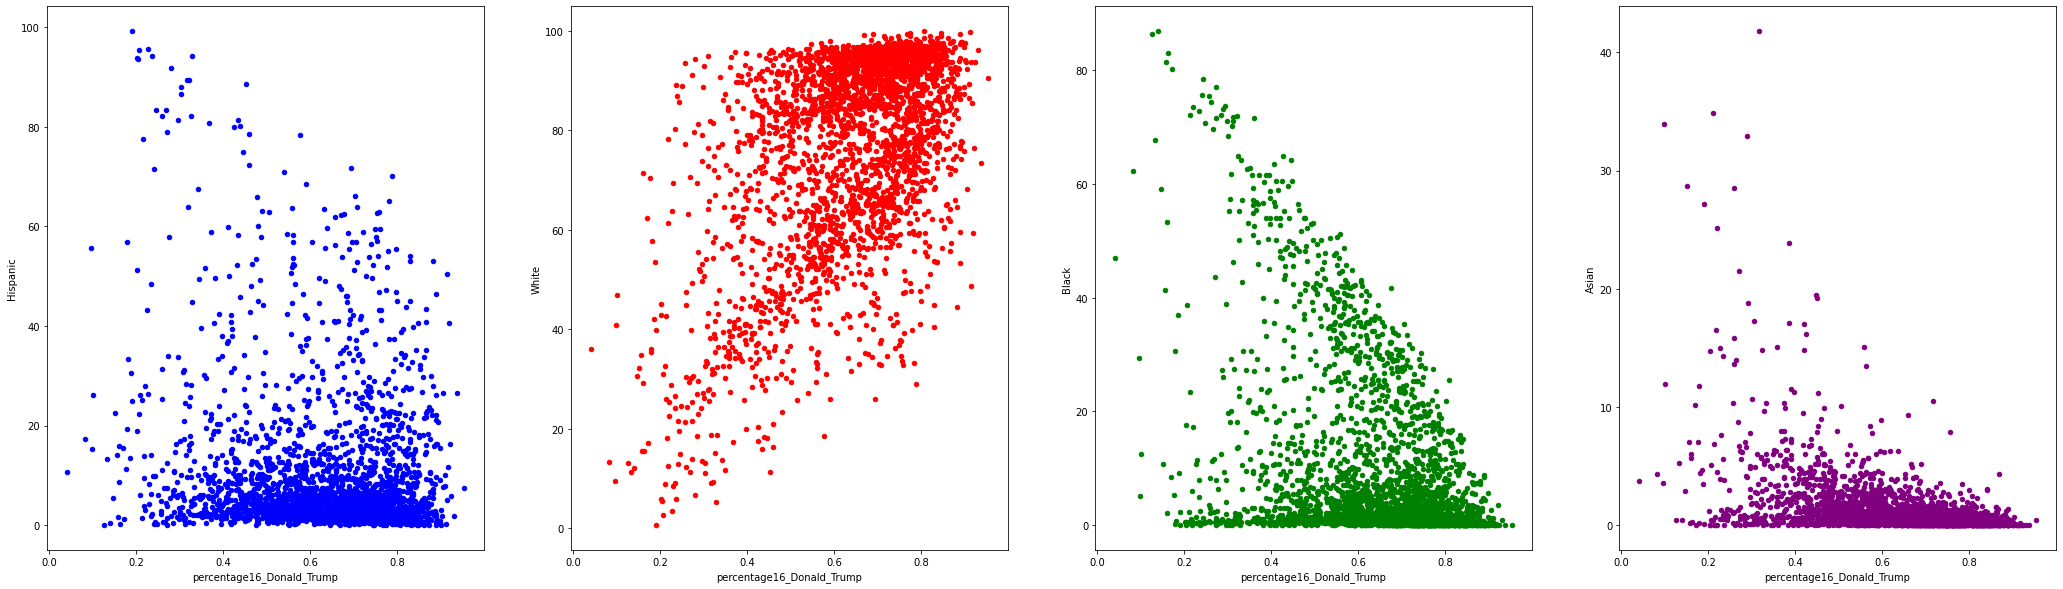

In [3]:
fig, ax = plt.subplots(nrows = 1, ncols=4, figsize=(36,10))

df.plot.scatter(x='percentage16_Donald_Trump', y='Hispanic', c='blue', ax=ax[0])
df.plot.scatter(x='percentage16_Donald_Trump', y='White', c='red', ax=ax[1])
df.plot.scatter(x='percentage16_Donald_Trump', y='Black', c='green', ax=ax[2])
df.plot.scatter(x='percentage16_Donald_Trump', y='Asian', c='purple', ax=ax[3])

When examining these plots, there are not obvious trends when it comes to Asian and Hispanic voters, but there seems to be clear positive correlation with White voters and negative correlation with Black voters. These two groups will be examined further. 

###**Race vs Voting 2** 

Based on the findings above, the voting of Black and White voters seems to be quite predictable. In the following section, we will formalize this.

Below, we use the 'Winner' tab to see if counties with a black or white majority will vote a certain way.

In [4]:
b = len(df[ (df['Black'] > 50) & (df['Winner'] == 'Hil')] ) / len(df[df['Black'] > 50])
w = len(df[ (df['White'] > 50) & (df['Winner'] == 'Donny')] ) / len(df[df['White'] > 50])
print('b:', b, '\nw', w)

b: 0.9340659340659341 
w 0.9164818920916482


What these values show:


*   *b* shows the proportion of black majority counties that voted for Hilary
*   *w* shows the proportion of white majority counties that voted for Trump

Thes values show clear positive correlation between the race and target candidate. Since we have found strong correlation, we can try to create a logistic regression model that predicts a winner based on the race demographics of a county.

### **Race vs Voting 3**

In [5]:
import sklearn.linear_model as mod
from sklearn import model_selection


# if you want items later in the sorted list to be penalized differently, enable sorting and change function
dct1 = mapToInt(df, 'Winner', False, 'linear')
df.dropna(inplace=True)

lst = list(df)
start = lst.index('White')
end = lst.index('Black') + 1
print(lst[start:end])

# designate X and Y variables
X = df[lst[start:end]]
y = df['Winner']

# use scikit data splitting feature to randomly select testing and training sets
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.15)

# create and fit model
# this model attempts to predict the fte_score given a pollster
model = mod.LogisticRegression()
model.fit(X=X_train, y=y_train)
pred = model.predict(X=X_test)

print('accuracy:')
skl.metrics.accuracy_score(y_test, pred)


['White', 'Black']
accuracy:


0.9146608315098468

In [6]:
lst = list(df)
start = lst.index('Hispanic')
end = lst.index('Pacific') + 1
print(lst[start:end])

# designate X and Y variables
X = df[lst[start:end]]
y = df['Winner']

# use scikit data splitting feature to randomly select testing and training sets
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.15)

# create and fit model
# this model attempts to predict the fte_score given a pollster
model = mod.LogisticRegression()
model.fit(X=X_train, y=y_train)
pred = model.predict(X=X_test)

print('accuracy:')
skl.metrics.accuracy_score(y_test, pred)


['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']
accuracy:


0.9190371991247265

Examining both models, it is clear that it is marginally better when including all races as features, but creating a model based on only black and white voters is very accurate as well; reinforcing the hypothesis that they have heavy correlation with a specific candidate.

I have not posted the exact percentages here as they will change due to the randomized test sample. The first model created is based only on black and white people and the second model is based on all races. 


## **Race Vs Covid Deaths 1**

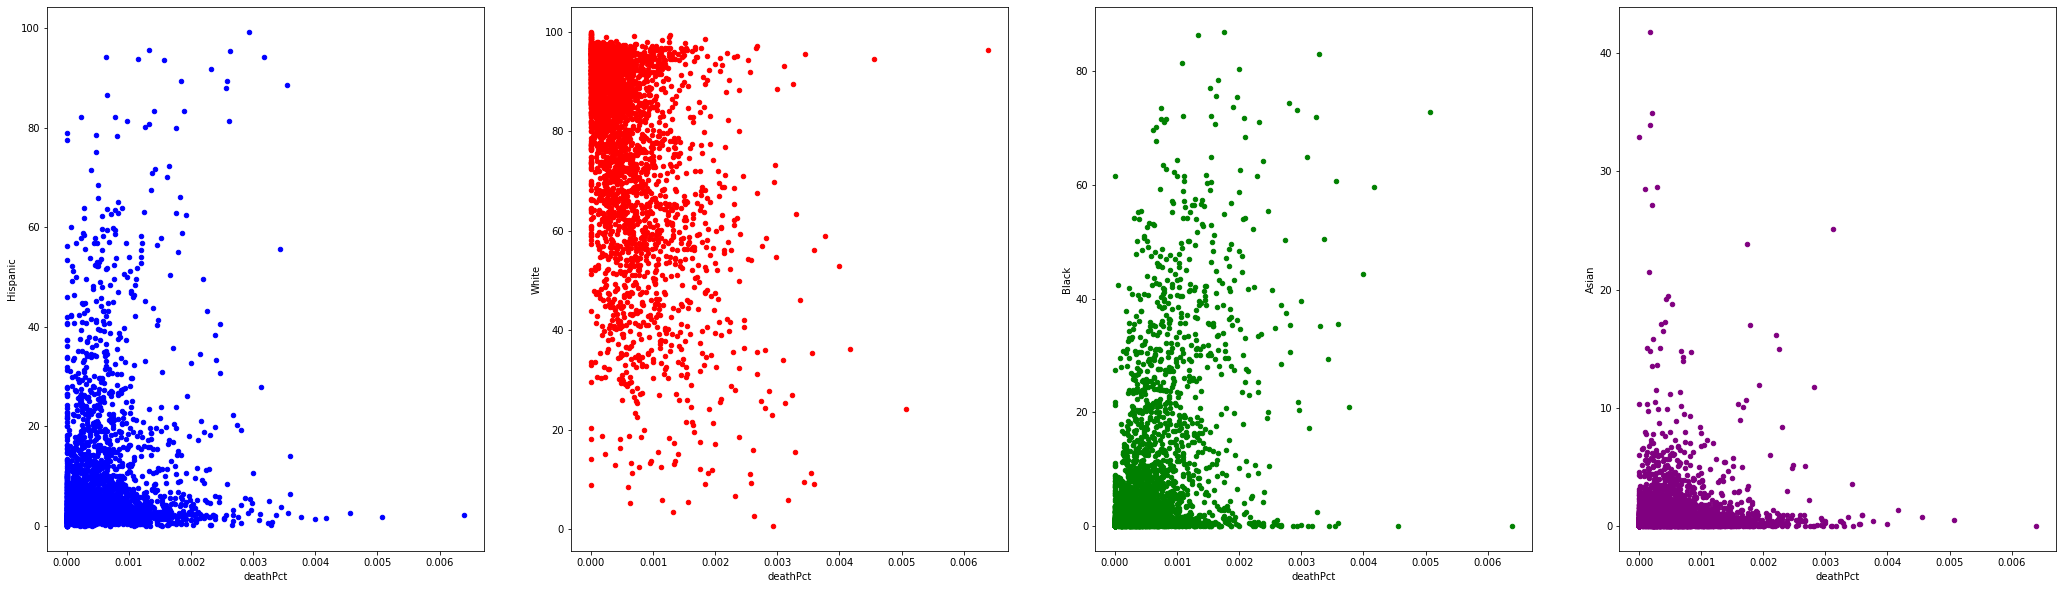

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols=4, figsize=(36,10))

df.plot.scatter(x='deathPct', y='Hispanic', c='blue', ax=ax[0])
df.plot.scatter(x='deathPct', y='White', c='red', ax=ax[1])
df.plot.scatter(x='deathPct', y='Black', c='green', ax=ax[2])
df.plot.scatter(x='deathPct', y='Asian', c='purple', ax=ax[3])

In all three of these plots, there is no clear trend, we can see that all the points are grouped along the axes, indicating that the death percentage is not related to the race. 

The next portion will examine possible relationships between the type of transportation used by a county and their voting or covid deaths.
## **Commute vs Voting 1**




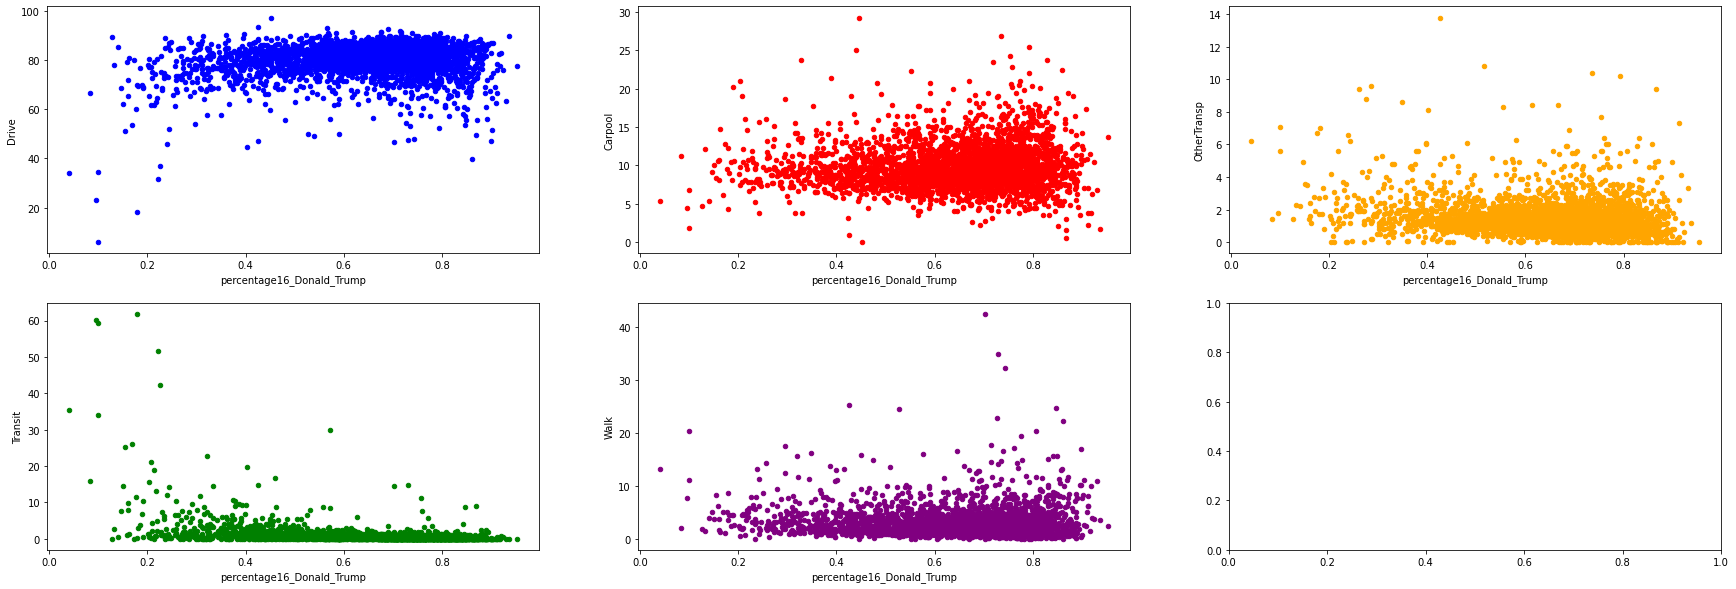

In [8]:
fig, ax = plt.subplots(nrows = 2, ncols=3, figsize= (30,10))

df.plot.scatter(x='percentage16_Donald_Trump', y='Drive', c='blue', ax=ax[0,0])
df.plot.scatter(x='percentage16_Donald_Trump', y='Carpool', c='red', ax=ax[0,1])
df.plot.scatter(x='percentage16_Donald_Trump', y='Transit', c='green', ax=ax[1,0])
df.plot.scatter(x='percentage16_Donald_Trump', y='Walk', c='purple', ax=ax[1,1])
df.plot.scatter(x='percentage16_Donald_Trump', y='OtherTransp', c='orange', ax=ax[0,2])


We can see here that all of the trends seem to be horizontal lines. This means that we generally have a constant percentage for each type of transportation, but the voting preferences vary. This means that the two variables are independent (one changes and not the other). Since there is no correlation, this does not require any further study. 

Even when considering the problem without looking at data, it does not make sense for someone's commute to affect their presidential voting very heavily. 

## **Commute vs Covid Deaths 1**


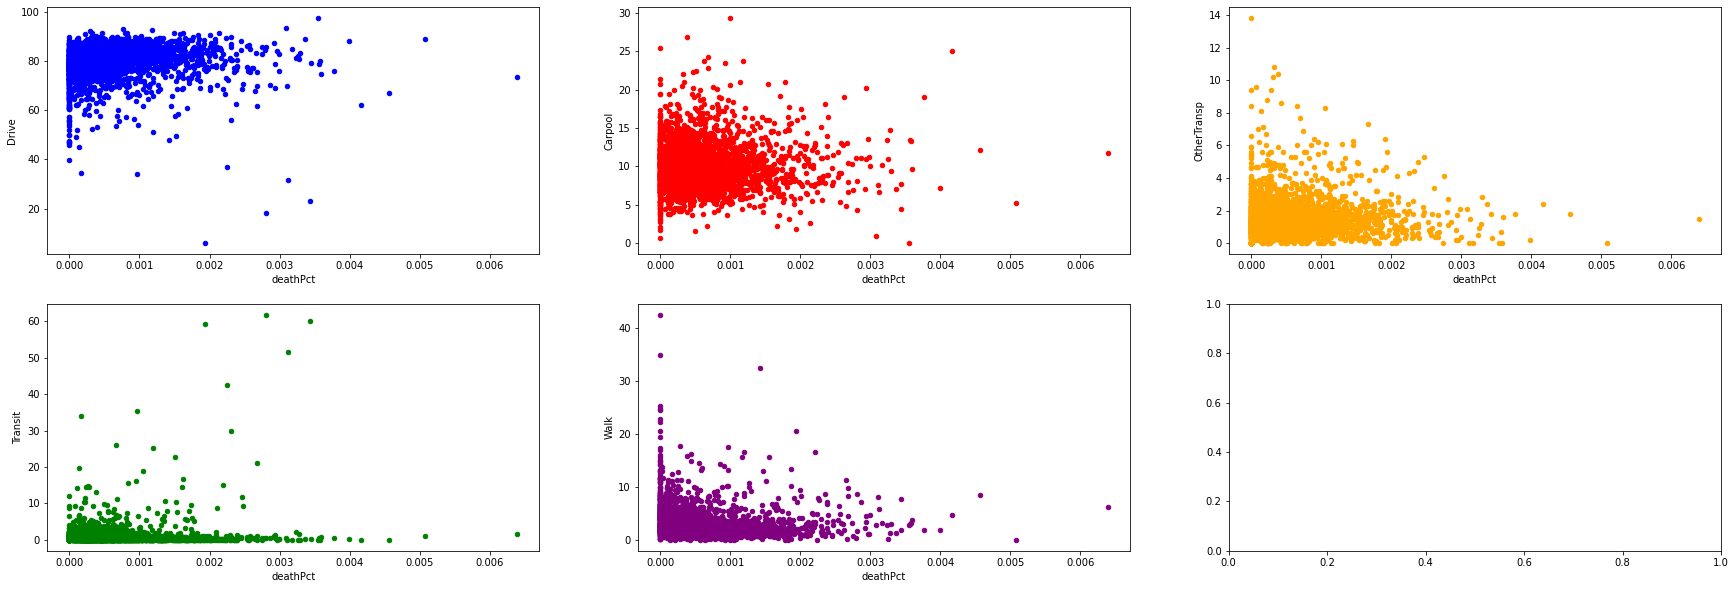

In [9]:
fig, ax = plt.subplots(nrows = 2, ncols=3, figsize= (30,10))

df.plot.scatter(x='deathPct', y='Drive', c='blue', ax=ax[0,0])
df.plot.scatter(x='deathPct', y='Carpool', c='red', ax=ax[0,1])
df.plot.scatter(x='deathPct', y='Transit', c='green', ax=ax[1,0])
df.plot.scatter(x='deathPct', y='Walk', c='purple', ax=ax[1,1])
df.plot.scatter(x='deathPct', y='OtherTransp', c='orange', ax=ax[0,2])

The trends in these scatter plots are the same as seen with voting preferences. It seems that commute type does not have any clear relationship with the effect of Covid on a particular county.

# **Data Analysis - Type / State of Employment**

In [10]:
 # EDA
employment_covid_df = select_columns_covid.copy()
employment_covid_df.set_index('county')

Employed  PrivateWork  PublicWork  ...  Unemployment  pctCases    cases
county                                        ...                                 
Abbeville    9505.0         78.8        13.3  ...           9.4  0.032475    805.0
Acadia      24982.0         80.0        12.1  ...           8.9  0.050825   3182.0
Accomack    13837.0         74.6        18.1  ...           5.4  0.037363   1227.0
Ada        214984.0         78.3        15.0  ...           4.3  0.040106  17451.0
Adair        3680.0         73.8        15.3  ...           3.0  0.030868    222.0
...             ...          ...         ...  ...           ...       ...      ...
Yuma        74891.0         74.4        20.8  ...          10.9  0.068504  13994.0
Yuma         4940.0         71.6        15.5  ...           2.4  0.022455    227.0
Zapata       5146.0         66.0        21.0  ...          12.4  0.024835    358.0
Zavala       4397.0         73.9        21.2  ...          10.1  0.038677    470.0
Ziebach       967.0         32.1        48.2  ...          27.0  0.038068    108.0

[3046 rows x 8 columns]

## **Covid Correlation**

We will take a subset of the data features out of the dataset as a whole and test their correlation with covid cases. We identify this subset as current state of employment / type of work.

In [11]:
employment_covid_df.describe()

Employed  PrivateWork  ...     pctCases          cases
count  3.046000e+03  3046.000000  ...  3046.000000    3046.000000
mean   4.795226e+04    75.216645  ...     0.028587    2902.460604
std    1.589466e+05     7.329497  ...     0.017564   10817.512225
min    3.900000e+01    32.100000  ...     0.000000       0.000000
25%    4.579000e+03    71.800000  ...     0.016524     241.250000
50%    1.068550e+04    76.400000  ...     0.026154     654.500000
75%    2.920425e+04    80.300000  ...     0.037638    1794.750000
max    4.805817e+06    88.800000  ...     0.204605  309190.000000

[8 rows x 8 columns]

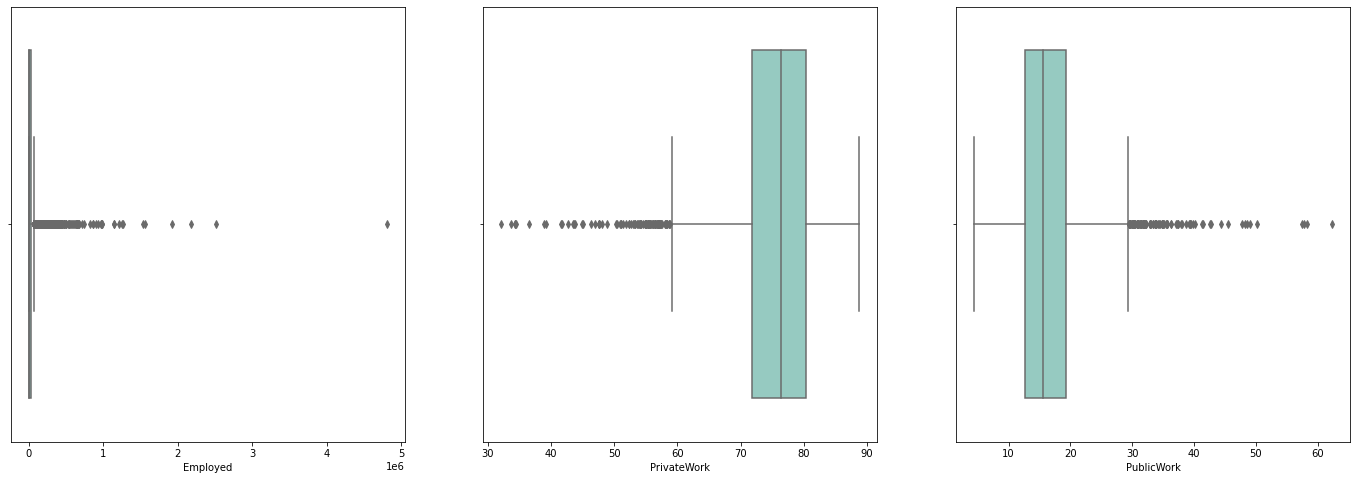

In [12]:
f, axes = plt.subplots(1,3, figsize=(24,8))
sns.boxplot(x="Employed" , data=employment_covid_df, palette="Set3",ax=axes[0])
sns.boxplot(x="PrivateWork" , data=employment_covid_df, palette="Set3", ax=axes[1])
sns.boxplot(x="PublicWork" , data=employment_covid_df, palette="Set3", ax=axes[2])

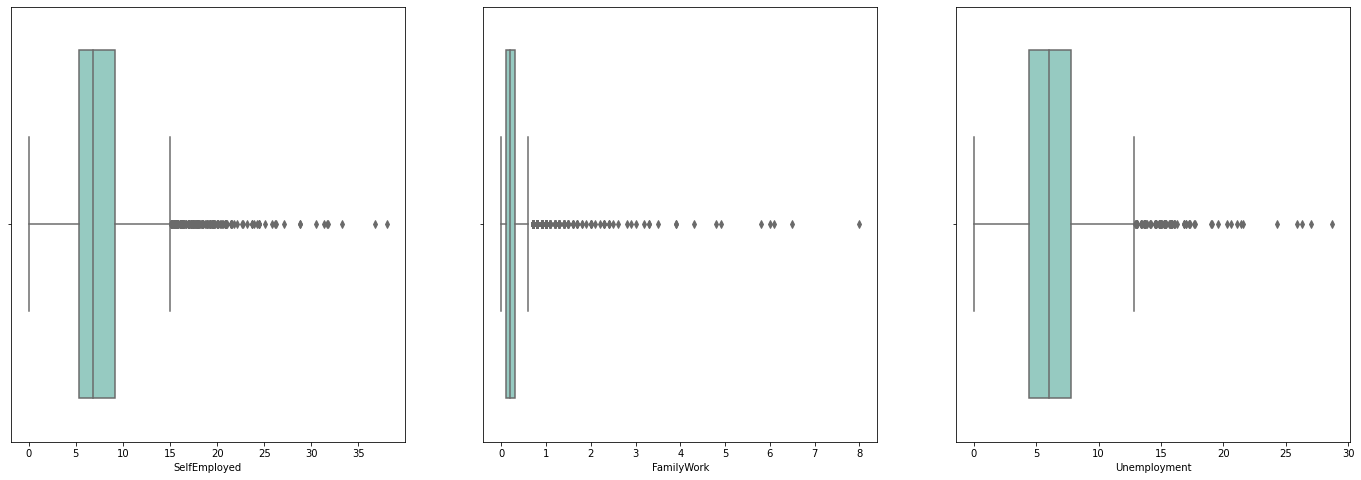

In [13]:
f, axes = plt.subplots(1,3, figsize=(24,8))
sns.boxplot(x="SelfEmployed" , data=employment_covid_df, palette="Set3",ax=axes[0])
sns.boxplot(x="FamilyWork" , data=employment_covid_df, palette="Set3", ax=axes[1])
sns.boxplot(x="Unemployment" , data=employment_covid_df, palette="Set3", ax=axes[2])

From our visualizations we can identify that our data is heavily skewed and full of outliers. Before we calculate correlation we will process the data further by removing outliers.

In [14]:
processed_employment_covid_df = employment_covid_df
dct_employ = mapToInt(processed_employment_covid_df, 'county', True, 'linear')
#dct_employ

In [15]:
z = np.abs(stats.zscore(processed_employment_covid_df))
processed_employment_covid_df = processed_employment_covid_df[(z < 3).all(axis=1)]
processed_employment_covid_df
processed_employment_covid_df.set_index('county')

Employed  PrivateWork  PublicWork  ...  Unemployment  pctCases    cases
county                                     ...                                 
1         9505.0         78.8        13.3  ...           9.4  0.032475    805.0
2        24982.0         80.0        12.1  ...           8.9  0.050825   3182.0
3        13837.0         74.6        18.1  ...           5.4  0.037363   1227.0
4       214984.0         78.3        15.0  ...           4.3  0.040106  17451.0
5         3680.0         73.8        15.3  ...           3.0  0.030868    222.0
...          ...          ...         ...  ...           ...       ...      ...
1764     27832.0         67.9        22.0  ...           9.9  0.018126   1353.0
1765     74891.0         74.4        20.8  ...          10.9  0.068504  13994.0
1765      4940.0         71.6        15.5  ...           2.4  0.022455    227.0
1766      5146.0         66.0        21.0  ...          12.4  0.024835    358.0
1767      4397.0         73.9        21.2  ...          10.1  0.038677    470.0

[2815 rows x 8 columns]

###**Covid Correlation Analysis**

After processing now we can run our correlation tests to see how these features connected to the percentage of cases and cases. We will look at scatter plots, correlation grids, and clustermaps to identify correlations.

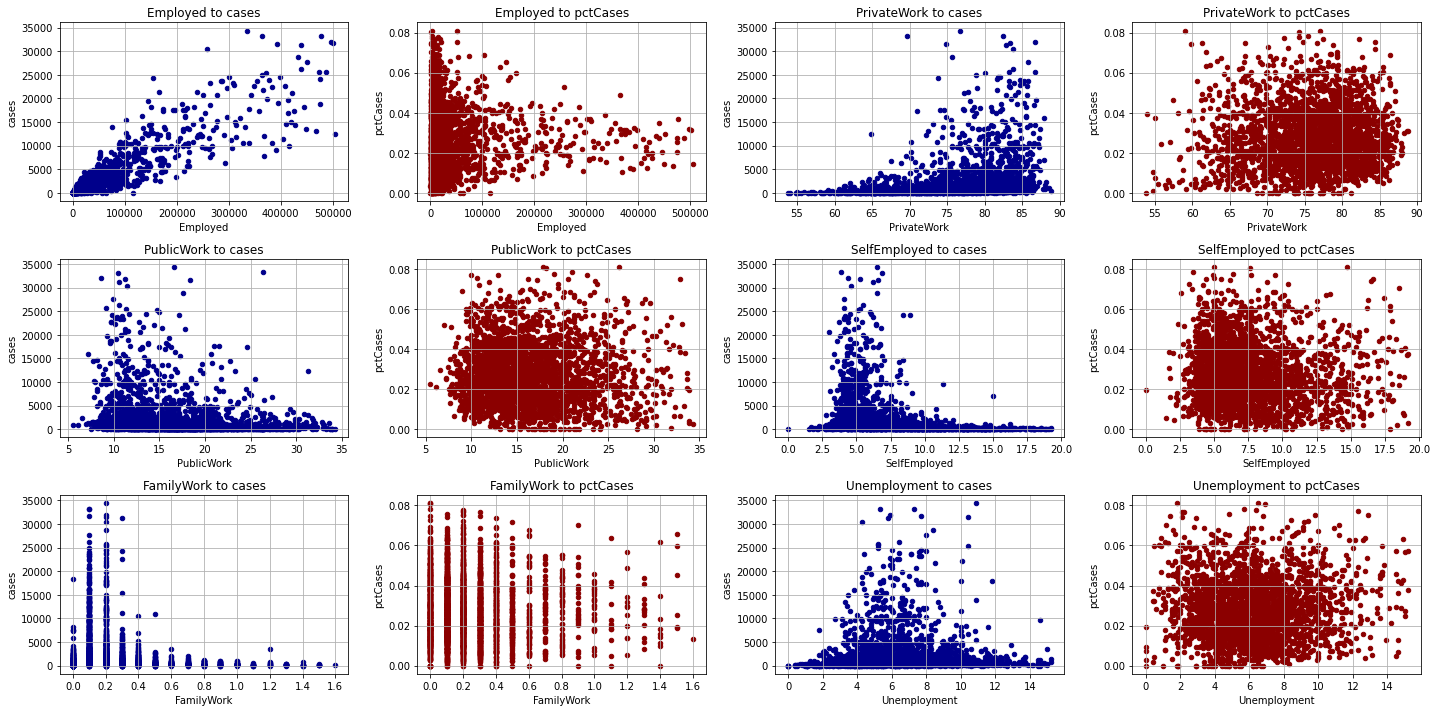

In [16]:
fig, ax = plt.subplots(nrows = 3, ncols=4, figsize= (20,10))
processed_employment_covid_df.plot(kind='scatter', x='Employed', y='cases',title="Employed to cases", grid=True,fontsize=10, color="DarkBlue", ax=ax[0,0])
processed_employment_covid_df.plot(kind='scatter', x='Employed', y='pctCases',title="Employed to pctCases", grid=True,fontsize=10, color="DarkRed" , ax=ax[0,1])

processed_employment_covid_df.plot(kind='scatter', x='PrivateWork', y='cases',title="PrivateWork to cases", grid=True,fontsize=10, color="DarkBlue", ax=ax[0,2]) 
processed_employment_covid_df.plot(kind='scatter', x='PrivateWork', y='pctCases',title="PrivateWork to pctCases", grid=True,fontsize=10, color="DarkRed", ax=ax[0,3]) 

processed_employment_covid_df.plot(kind='scatter', x='PublicWork', y='cases',title="PublicWork to cases", grid=True,fontsize=10, color="DarkBlue", ax=ax[1,0]) 
processed_employment_covid_df.plot(kind='scatter', x='PublicWork', y='pctCases',title="PublicWork to pctCases", grid=True,fontsize=10, color="DarkRed", ax=ax[1,1]) 

processed_employment_covid_df.plot(kind='scatter', x='SelfEmployed', y='cases',title="SelfEmployed to cases", grid=True,fontsize=10, color="DarkBlue", ax=ax[1,2]) 
processed_employment_covid_df.plot(kind='scatter', x='SelfEmployed', y='pctCases',title="SelfEmployed to pctCases", grid=True,fontsize=10, color="DarkRed", ax=ax[1,3]) 

processed_employment_covid_df.plot(kind='scatter', x='FamilyWork', y='cases',title="FamilyWork to cases", grid=True,fontsize=10, color="DarkBlue", ax=ax[2,0]) 
processed_employment_covid_df.plot(kind='scatter', x='FamilyWork', y='pctCases',title="FamilyWork to pctCases", grid=True,fontsize=10, color="DarkRed", ax=ax[2,1]) 

processed_employment_covid_df.plot(kind='scatter', x='Unemployment', y='cases',title="Unemployment to cases", grid=True,fontsize=10, color="DarkBlue", ax=ax[2,2]) 
processed_employment_covid_df.plot(kind='scatter', x='Unemployment', y='pctCases',title="Unemployment to pctCases", grid=True,fontsize=10, color="DarkRed", ax=ax[2,3]) 
fig.tight_layout()

county  Employed  PrivateWork  ...  Unemployment  pctCases     cases
county        1.000000  0.013585     0.017780  ...      0.016459 -0.007501  0.015599
Employed      0.013585  1.000000     0.312786  ...      0.009459 -0.028925  0.900739
PrivateWork   0.017780  0.312786     1.000000  ...     -0.035402  0.044715  0.301866
PublicWork   -0.012470 -0.197024    -0.847842  ...      0.232636 -0.019848 -0.179331
SelfEmployed -0.011926 -0.279990    -0.566048  ...     -0.292088 -0.053366 -0.287516
FamilyWork   -0.029743 -0.149801    -0.219980  ...     -0.135668 -0.017055 -0.144452
Unemployment  0.016459  0.009459    -0.035402  ...      1.000000  0.025863  0.049353
pctCases     -0.007501 -0.028925     0.044715  ...      0.025863  1.000000  0.179233
cases         0.015599  0.900739     0.301866  ...      0.049353  0.179233  1.000000

[9 rows x 9 columns]

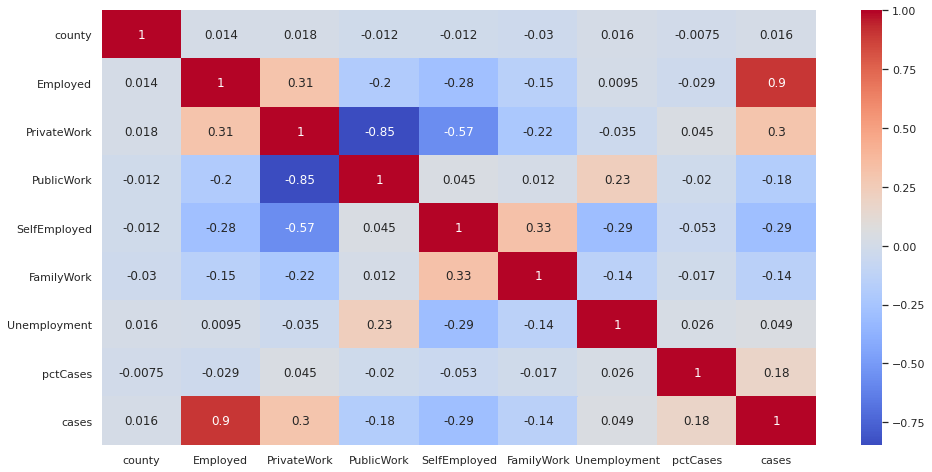

In [17]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = processed_employment_covid_df.corr()

sns.heatmap(corr, annot=True,cmap = "coolwarm")
processed_employment_covid_df.corr(method='pearson', min_periods=1)

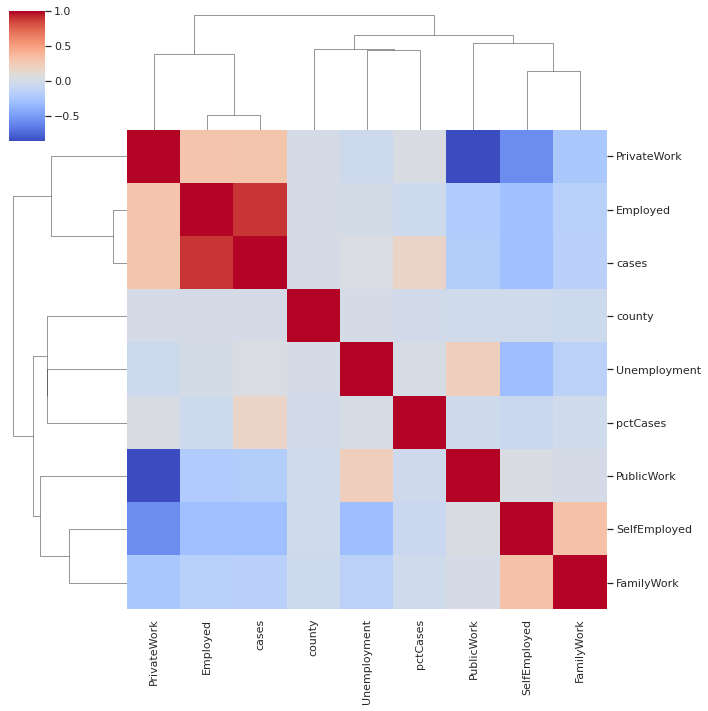

In [18]:
sns.clustermap(corr, cmap="coolwarm")

###**Covid Correlation Conclusion**
From our correlation analysis we can see the type of employment has little correlation with cases and percentage of cases, but the state of employment has a very strong correlation with number of cases.

##**Election Correlation**

Next we will test 2016 election data in our correlation analysis

In [19]:
employment_2016_df = select_columns_2016.copy()
employment_2016_df.set_index('county')

Employed  PrivateWork  ...  votes16_Donald_Trump  votes16_Hillary_Clinton
county                            ...                                               
Abbeville    9505.0         78.8  ...                6742.0                   3712.0
Acadia      24982.0         80.0  ...               21159.0                   5638.0
Accomack    13837.0         74.6  ...                8582.0                   6737.0
Ada        214984.0         78.3  ...               93748.0                  75676.0
Adair        3680.0         73.8  ...                2456.0                   1127.0
...             ...          ...  ...                   ...                      ...
Yuma        74891.0         74.4  ...               20586.0                  18336.0
Yuma         4940.0         71.6  ...                3755.0                    701.0
Zapata       5146.0         66.0  ...                1028.0                   2056.0
Zavala       4397.0         73.9  ...                 692.0                   2633.0
Ziebach       967.0         32.1  ...                 368.0                    352.0

[3046 rows x 11 columns]

In [20]:
employment_2016_df.describe()

Employed  PrivateWork  ...  votes16_Donald_Trump  votes16_Hillary_Clinton
count  3.046000e+03  3046.000000  ...           3046.000000             3.046000e+03
mean   4.795226e+04    75.216645  ...          19358.344714             1.924069e+04
std    1.589466e+05     7.329497  ...          39264.260944             6.835977e+04
min    3.900000e+01    32.100000  ...             57.000000             4.000000e+00
25%    4.579000e+03    71.800000  ...           3206.500000             1.144500e+03
50%    1.068550e+04    76.400000  ...           7113.000000             3.069500e+03
75%    2.920425e+04    80.300000  ...          17315.250000             9.192250e+03
max    4.805817e+06    88.800000  ...         590465.000000             1.654626e+06

[8 rows x 11 columns]

In [21]:
dct_employ = mapToInt(employment_2016_df, 'county', True, 'linear')
#dct_employ

In [22]:
z = np.abs(stats.zscore(employment_2016_df))
processed_employment_2016_df = employment_2016_df[(z < 3).all(axis=1)]
processed_employment_2016_df
processed_employment_2016_df.set_index('county')

Employed  PrivateWork  ...  votes16_Donald_Trump  votes16_Hillary_Clinton
county                         ...                                               
1         9505.0         78.8  ...                6742.0                   3712.0
2        24982.0         80.0  ...               21159.0                   5638.0
3        13837.0         74.6  ...                8582.0                   6737.0
4       214984.0         78.3  ...               93748.0                  75676.0
5         3680.0         73.8  ...                2456.0                   1127.0
...          ...          ...  ...                   ...                      ...
1763      8248.0         69.8  ...                6587.0                    873.0
1764     27832.0         67.9  ...                8869.0                   5115.0
1765     74891.0         74.4  ...               20586.0                  18336.0
1765      4940.0         71.6  ...                3755.0                    701.0
1766      5146.0         66.0  ...                1028.0                   2056.0

[2787 rows x 11 columns]

### Election Correlation Analysis

Now we will run the same correlation tests but with percentage of votes for both 2016 presidential candidates

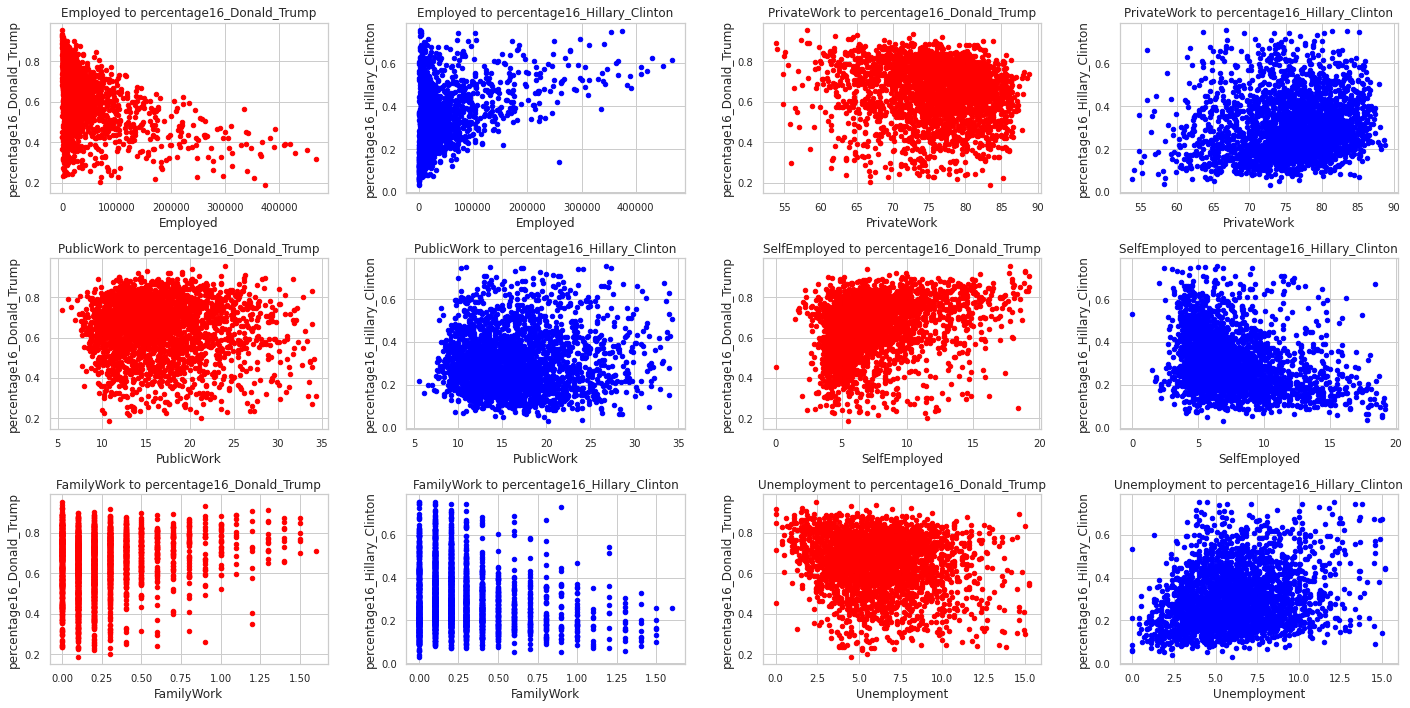

In [23]:
fig, ax = plt.subplots(nrows = 3, ncols=4, figsize= (20,10))
processed_employment_2016_df.plot(kind='scatter', x='Employed', y='percentage16_Donald_Trump',title="Employed to percentage16_Donald_Trump", grid=True,fontsize=10, color="Red" , ax=ax[0,0]) 
processed_employment_2016_df.plot(kind='scatter', x='Employed', y='percentage16_Hillary_Clinton',title="Employed to percentage16_Hillary_Clinton", grid=True,fontsize=10, color="Blue" , ax=ax[0,1]) 

processed_employment_2016_df.plot(kind='scatter', x='PrivateWork', y='percentage16_Donald_Trump',title="PrivateWork to percentage16_Donald_Trump", grid=True,fontsize=10, color="Red" , ax=ax[0,2]) 
processed_employment_2016_df.plot(kind='scatter', x='PrivateWork', y='percentage16_Hillary_Clinton',title="PrivateWork to percentage16_Hillary_Clinton", grid=True,fontsize=10, color="Blue", ax=ax[0,3]) 

processed_employment_2016_df.plot(kind='scatter', x='PublicWork', y='percentage16_Donald_Trump',title="PublicWork to percentage16_Donald_Trump", grid=True,fontsize=10, color="Red", ax=ax[1,0]) 
processed_employment_2016_df.plot(kind='scatter', x='PublicWork', y='percentage16_Hillary_Clinton',title="PublicWork to percentage16_Hillary_Clinton", grid=True,fontsize=10, color="Blue", ax=ax[1,1]) 

processed_employment_2016_df.plot(kind='scatter', x='SelfEmployed', y='percentage16_Donald_Trump',title="SelfEmployed to percentage16_Donald_Trump", grid=True,fontsize=10, color="Red", ax=ax[1,2]) 
processed_employment_2016_df.plot(kind='scatter', x='SelfEmployed', y='percentage16_Hillary_Clinton',title="SelfEmployed to percentage16_Hillary_Clinton", grid=True,fontsize=10, color="Blue", ax=ax[1,3]) 

processed_employment_2016_df.plot(kind='scatter', x='FamilyWork', y='percentage16_Donald_Trump',title="FamilyWork to percentage16_Donald_Trump", grid=True,fontsize=10, color="Red", ax=ax[2,0]) 
processed_employment_2016_df.plot(kind='scatter', x='FamilyWork', y='percentage16_Hillary_Clinton',title="FamilyWork to percentage16_Hillary_Clinton", grid=True,fontsize=10, color="Blue", ax=ax[2,1]) 

processed_employment_2016_df.plot(kind='scatter', x='Unemployment', y='percentage16_Donald_Trump',title="Unemployment to percentage16_Donald_Trump", grid=True,fontsize=10, color="Red", ax=ax[2,2]) 
processed_employment_2016_df.plot(kind='scatter', x='Unemployment', y='percentage16_Hillary_Clinton',title="Unemployment to percentage16_Hillary_Clinton", grid=True,fontsize=10, color="Blue", ax=ax[2,3]) 
fig.tight_layout()

county  ...  votes16_Hillary_Clinton
county                        1.000000  ...                 0.012094
Employed                      0.020825  ...                 0.956193
PrivateWork                   0.017027  ...                 0.255486
PublicWork                   -0.009182  ...                -0.137574
SelfEmployed                 -0.015395  ...                -0.263675
FamilyWork                   -0.032257  ...                -0.149756
Unemployment                  0.015759  ...                 0.021200
percentage16_Donald_Trump    -0.024604  ...                -0.519234
percentage16_Hillary_Clinton  0.023782  ...                 0.516442
total_votes16                 0.015447  ...                 0.966762
votes16_Donald_Trump          0.017395  ...                 0.851052
votes16_Hillary_Clinton       0.012094  ...                 1.000000

[12 rows x 12 columns]

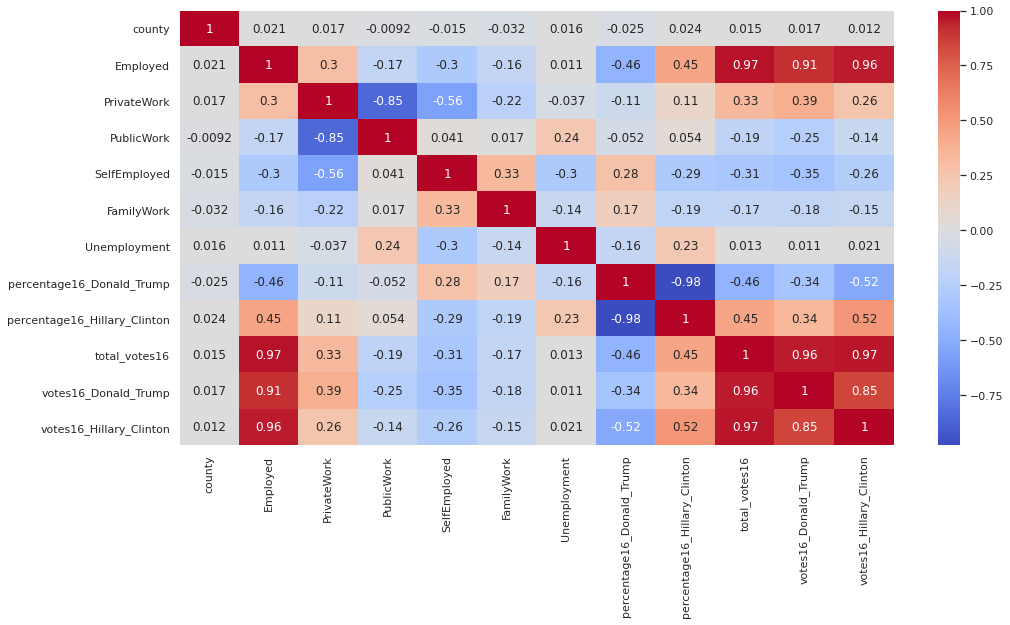

In [24]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
election_corr = processed_employment_2016_df.corr()

sns.heatmap(election_corr, annot=True,cmap = "coolwarm")
processed_employment_2016_df.corr(method='pearson', min_periods=1)

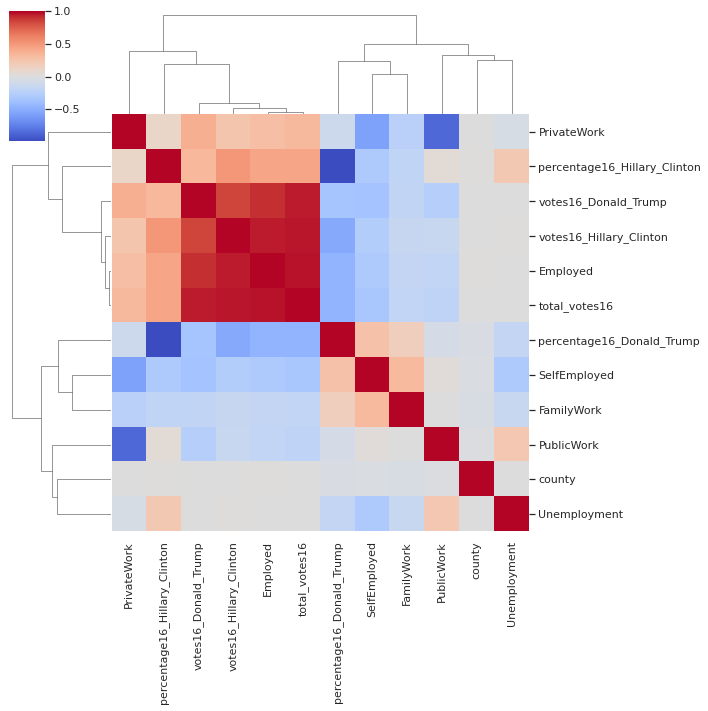

In [25]:
sns.clustermap(election_corr, cmap="coolwarm")

### **Election Correlation Conclusion**

From our correlation analysis we can conclude that more people who are employed voted more for Hillary clinton while unemployed people voted for Donald Trump

# Income/Poverty to Cases
In this subset of data we want to perform EDA to find correlation between the number of percent cases to the income / incomepercap / poverty of a county. We want to see how these features affect the number of cases of a county.

In [26]:
sns.set(font_scale= 1.3)
incomedf = df[['Income', 'IncomePerCap', 'Poverty']].copy()
incomedf = incomedf.dropna()
incomedf['casesPCT'] = 100 * df['cases'] / df['TotalPop']
incomedf.describe()

Income  IncomePerCap      Poverty     casesPCT
count    3046.000000   3046.000000  3046.000000  3046.000000
mean    49507.418910  25914.910703    15.991399     2.858666
std     12867.220397   6115.954824     6.498167     1.756390
min     19264.000000  10960.000000     2.400000     0.000000
25%     41115.000000  21782.000000    11.400000     1.652449
50%     47938.000000  25211.000000    15.200000     2.615448
75%     55433.250000  28940.750000    19.300000     3.763786
max    129588.000000  69529.000000    52.000000    20.460504

### Creating box plots for each column and finding outliers to process the data to be more precise
We want to find if there are any outliers in our data that could be skewing the data. 

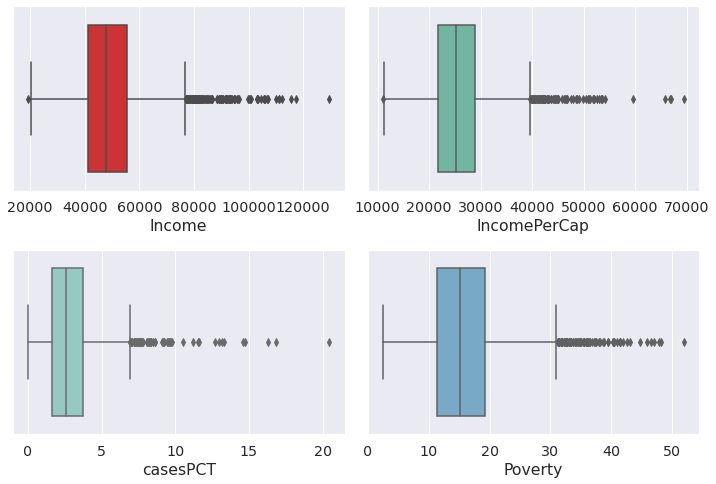

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
sns.boxplot(x="Income" ,data=incomedf, palette="Set1", ax=axes[0, 0])
sns.boxplot(x="IncomePerCap",data=incomedf, palette="Set2",ax=axes[0, 1])
sns.boxplot(x="casesPCT",data=incomedf, palette="Set3",ax=axes[1, 0])
sns.boxplot(x="Poverty",data=incomedf, palette="Blues",ax=axes[1, 1])
fig.tight_layout()
plt.show()

### Correlation between each feature and percent cases

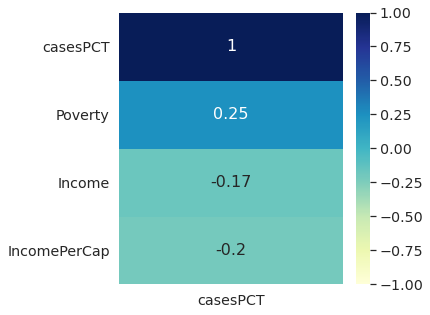

In [28]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(incomedf.corr()[['casesPCT']].sort_values('casesPCT').tail(6),
 vmax=1, vmin=-1, cmap='YlGnBu', annot_kws={'size':16}, annot=True, ax=ax);
ax.invert_yaxis()

Most of the features are positively skewed looking at the box plots above. This means we can try looking for potential outliers. There is also a correlation chart of each of the features compared to cases percentage. From this we see that there is a slight positive correlation between cases percentage and poverty. We also see that there is a slight negative correlation between Income and IncomePerCap to cases percentage. We want to try to get a more tight data and eliminate outliers using the z-score method.

### z-score outliers elimination

In [29]:
z_scores = stats.zscore(incomedf)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_income_df = incomedf[filtered_entries]
new_income_df.describe()

Income  IncomePerCap      Poverty     casesPCT
count   2913.000000    2913.00000  2913.000000  2913.000000
mean   48877.731205   25647.25884    15.833024     2.755892
std    10855.268358    5115.30627     5.789673     1.505729
min    22736.000000   11192.00000     2.400000     0.000000
25%    41197.000000   21858.00000    11.500000     1.639344
50%    47873.000000   25190.00000    15.200000     2.595694
75%    55000.000000   28633.00000    19.300000     3.714494
max    86781.000000   43736.00000    35.300000     8.104187

### Box plots after removing outliers

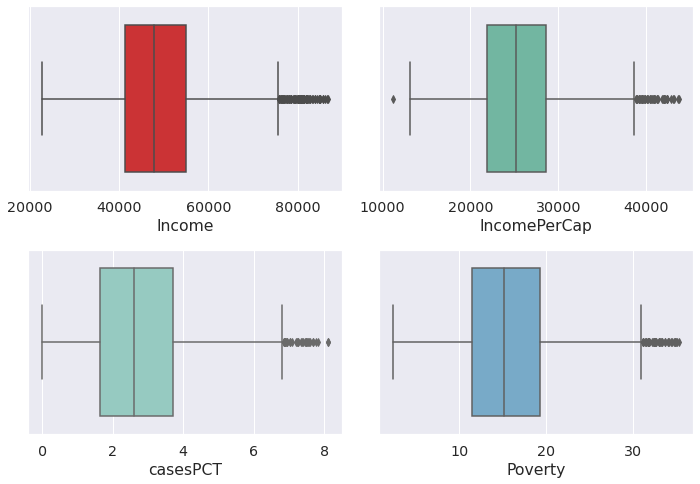

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
sns.boxplot(x="Income" ,data=new_income_df, palette="Set1",ax=axes[0, 0])
sns.boxplot(x="IncomePerCap",data=new_income_df, palette="Set2",ax=axes[0, 1])
sns.boxplot(x="casesPCT",data=new_income_df, palette="Set3",ax=axes[1, 0])
sns.boxplot(x="Poverty",data=new_income_df, palette="Blues",ax=axes[1, 1])
fig.tight_layout()
plt.show()

### Scatter plot of each feature to percent cases

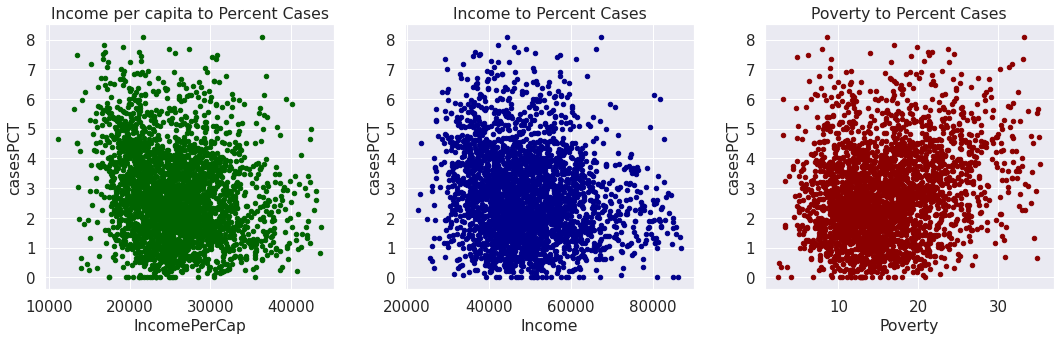

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
new_income_df.plot(kind='scatter', x='IncomePerCap', y='casesPCT',title="Income per capita to Percent Cases", grid=True,fontsize=15, color="DarkGreen", ax=axes[0])
new_income_df.plot(kind='scatter', x='Income', y='casesPCT',title="Income to Percent Cases", grid=True,fontsize=15, color="DarkBlue", ax=axes[1]) 
new_income_df.plot(kind='scatter', x='Poverty', y='casesPCT',title="Poverty to Percent Cases", grid=True,fontsize=15, color="DarkRed", ax=axes[2])
fig.tight_layout()
plt.show()

### Correlation between each feature and percent cases

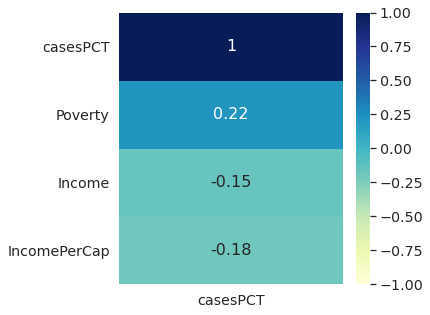

In [32]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(new_income_df.corr()[['casesPCT']].sort_values('casesPCT').tail(6),
 vmax=1, vmin=-1, cmap='YlGnBu', annot=True, annot_kws={'size':16}, ax=ax);
ax.invert_yaxis()

From this analysis after removing the potential outliers, we find there isnt much change, this means that outliers didn't affect the data heavily. Poverty has a slight positive correlation with the percent cases, this means that it is possible that the areas with more proverty has more cases of coronavirus. Looking at the income correlation with percent cases, we find that it is possible that areas that have more income could possible be less exposed to the coronavirus.

# Income/Poverty to Candidate Percentage Votes

In [33]:
election_income_df = df[['percentage16_Donald_Trump', 'percentage16_Hillary_Clinton','Income', 'IncomePerCap', 'Poverty']].copy()
election_income_df = election_income_df.dropna()
election_income_df.describe()

percentage16_Donald_Trump  ...      Poverty
count                3046.000000  ...  3046.000000
mean                    0.640883  ...    15.991399
std                     0.152413  ...     6.498167
min                     0.041000  ...     2.400000
25%                     0.557000  ...    11.400000
50%                     0.670000  ...    15.200000
75%                     0.752000  ...    19.300000
max                     0.953000  ...    52.000000

[8 rows x 5 columns]

### Creating box plots for each column and finding outliers to process the data to be more precise
We want to find if there are any outliers in our data that could be skewing the data. 

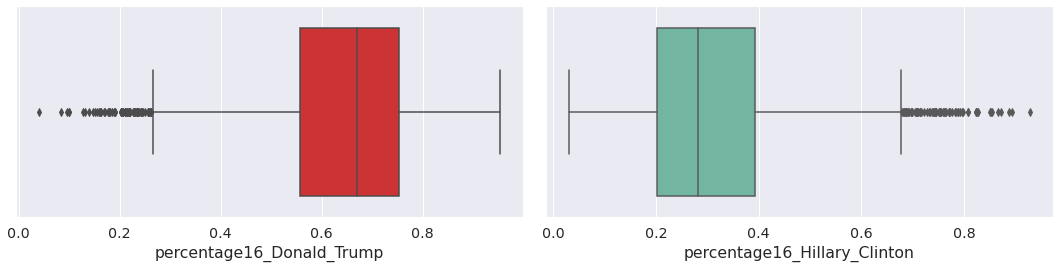

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.boxplot(x="percentage16_Donald_Trump" ,data=election_income_df, palette="Set1",ax=axes[0])
sns.boxplot(x="percentage16_Hillary_Clinton",data=election_income_df, palette="Set2",ax=axes[1])
fig.tight_layout()
plt.show()

### Correlation between each feature and percentage votes for each candidate

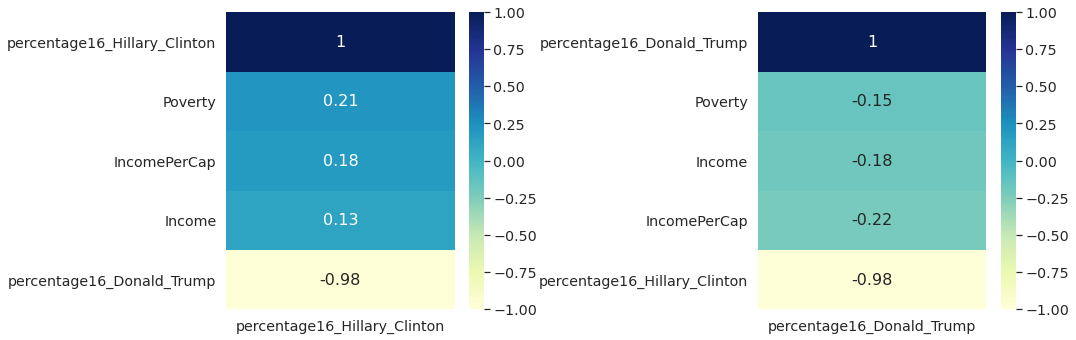

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(election_income_df.corr()[['percentage16_Hillary_Clinton']].sort_values('percentage16_Hillary_Clinton').tail(6), annot_kws={'size':16}, vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax[0]);
sns.heatmap(election_income_df.corr()[['percentage16_Donald_Trump']].sort_values('percentage16_Donald_Trump').tail(6),annot_kws={'size':16}, vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax[1]);
fig.tight_layout()
ax[0].invert_yaxis()
ax[1].invert_yaxis()

### z-score outliers elimination

In [36]:
z_scores = stats.zscore(election_income_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_election_df = election_income_df[filtered_entries]
new_election_df.describe()

percentage16_Donald_Trump  ...      Poverty
count                2925.000000  ...  2925.000000
mean                    0.651125  ...    15.806838
std                     0.140971  ...     5.767751
min                     0.188000  ...     2.400000
25%                     0.570000  ...    11.500000
50%                     0.676000  ...    15.200000
75%                     0.755000  ...    19.200000
max                     0.953000  ...    35.300000

[8 rows x 5 columns]

### Box plots after removing outliers

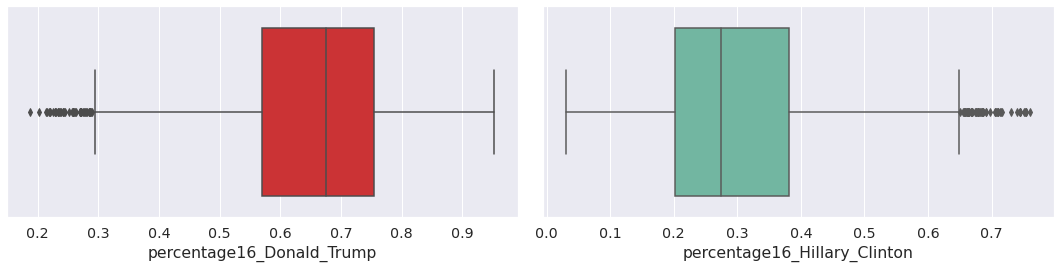

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.boxplot(x="percentage16_Donald_Trump" ,data=new_election_df, palette="Set1",ax=axes[0])
sns.boxplot(x="percentage16_Hillary_Clinton",data=new_election_df, palette="Set2",ax=axes[1])
fig.tight_layout()
plt.show()

We can see the box plots above in which the trump box plot is negatively skewed while hilary's box plot is posively skewed. This is due to trump receiving more votes than hilary. Now we can further analyze if Income/Poverty features have any effect on the data.

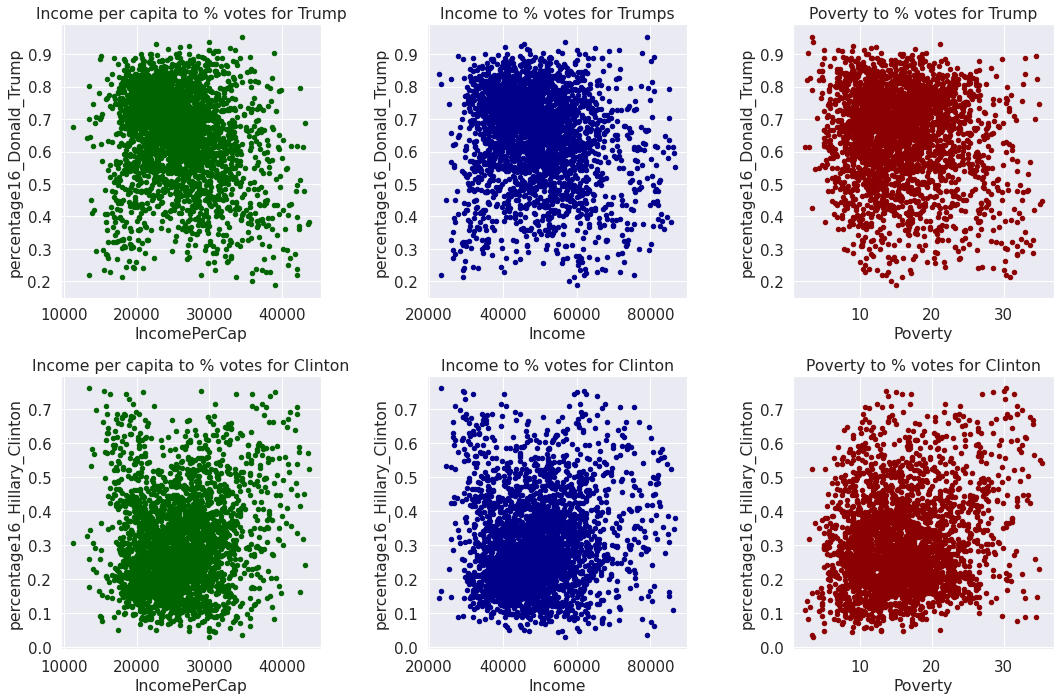

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
new_election_df.plot(kind='scatter', x='IncomePerCap', y='percentage16_Donald_Trump',title="Income per capita to % votes for Trump", grid=True,fontsize=15, color="DarkGreen", ax=axes[0, 0])
new_election_df.plot(kind='scatter', x='Income', y='percentage16_Donald_Trump',title="Income to % votes for Trumps", grid=True,fontsize=15, color="DarkBlue", ax=axes[0, 1]) 
new_election_df.plot(kind='scatter', x='Poverty', y='percentage16_Donald_Trump',title="Poverty to % votes for Trump", grid=True,fontsize=15, color="DarkRed", ax=axes[0, 2])
new_election_df.plot(kind='scatter', x='IncomePerCap', y='percentage16_Hillary_Clinton',title="Income per capita to % votes for Clinton", grid=True,fontsize=15, color="DarkGreen", ax=axes[1, 0])
new_election_df.plot(kind='scatter', x='Income', y='percentage16_Hillary_Clinton',title="Income to % votes for Clinton", grid=True,fontsize=15, color="DarkBlue", ax=axes[1, 1]) 
new_election_df.plot(kind='scatter', x='Poverty', y='percentage16_Hillary_Clinton',title="Poverty to % votes for Clinton", grid=True,fontsize=15, color="DarkRed", ax=axes[1, 2])
fig.tight_layout()
plt.show()

### Correlation between each feature and percentage votes for each candidate

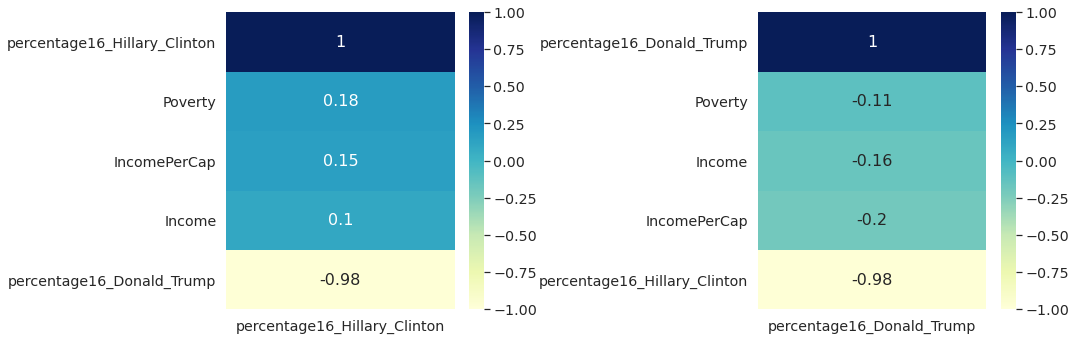

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(new_election_df.corr()[['percentage16_Hillary_Clinton']].sort_values('percentage16_Hillary_Clinton').tail(6), vmax=1, vmin=-1, cmap='YlGnBu', annot_kws={'size':16}, annot=True, ax=ax[0]);
sns.heatmap(new_election_df.corr()[['percentage16_Donald_Trump']].sort_values('percentage16_Donald_Trump').tail(6), vmax=1, vmin=-1, cmap='YlGnBu',annot_kws={'size':16}, annot=True, ax=ax[1]);
fig.tight_layout()
ax[0].invert_yaxis()
ax[1].invert_yaxis()

From the heat maps above we can see the correlation between the features and the percent votes for each candidate. If we look at Hilary Clinton, we see that Income and Poverty have a really slight positive correlation to percent votes. It is possible that if a certain county has more poverty, we can make an assumption that they are possibly going to vote for clinton and comparing this to trump who has a really slight negative correlation, we see that these attributes have a very slight negative correlation.

In [40]:
sns.set(font_scale= 1)

# Hridya


##Analysis - Sector/Covid

In [41]:
# EDA
#Business Sector: Professional, Service, Office, Construction, Production

select_sector_columns_covid = df[['county', 'Professional', 'Service', 'Office', 'Construction', 'Production', 'pctCases', 'cases']]
select_sector_columns_2016 = df[['county', 'Professional', 'Service', 'Office', 'Construction', 'Production', 'percentage16_Donald_Trump', 'percentage16_Hillary_Clinton', 'total_votes16', 'votes16_Donald_Trump', 'votes16_Hillary_Clinton']]

sector_covid_df = select_sector_columns_covid.copy()
sector_covid_df.set_index('county')

Professional  Service  Office  ...  Production  pctCases    cases
county                                    ...                               
Abbeville          27.2     20.7    20.8  ...        20.7  0.032475    805.0
Acadia             27.6     16.9    25.7  ...        14.8  0.050825   3182.0
Accomack           31.1     17.7    18.8  ...        17.3  0.037363   1227.0
Ada                43.0     16.6    25.0  ...         8.4  0.040106  17451.0
Adair              28.2     16.9    20.0  ...        17.6  0.030868    222.0
...                 ...      ...     ...  ...         ...       ...      ...
Yuma               24.9     23.0    22.8  ...        12.0  0.068504  13994.0
Yuma               29.4     14.4    22.2  ...        12.6  0.022455    227.0
Zapata             17.7     30.4    14.9  ...        20.2  0.024835    358.0
Zavala             29.0     24.3    14.7  ...        15.3  0.038677    470.0
Ziebach            51.3     15.9    15.6  ...         6.1  0.038068    108.0

[3046 rows x 7 columns]

## Sector/Covid Correlation

The following table shows a subset of the dataset (the different job sectors) and their correlation with covid cases.

In [42]:
sector_covid_df.describe()

Professional      Service  ...     pctCases          cases
count   3046.000000  3046.000000  ...  3046.000000    3046.000000
mean      31.423244    18.077183  ...     0.028587    2902.460604
std        6.426838     3.657206  ...     0.017564   10817.512225
min       11.400000     0.000000  ...     0.000000       0.000000
25%       27.200000    15.700000  ...     0.016524     241.250000
50%       30.500000    17.700000  ...     0.026154     654.500000
75%       34.800000    20.000000  ...     0.037638    1794.750000
max       69.000000    46.400000  ...     0.204605  309190.000000

[8 rows x 7 columns]

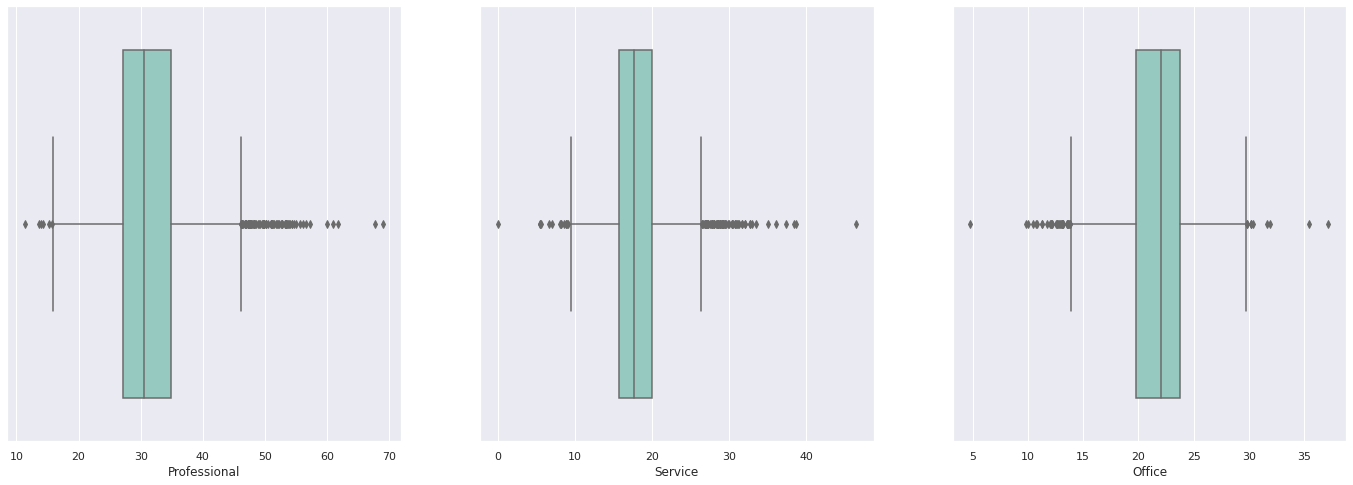

In [43]:
f, axes = plt.subplots(1,3, figsize=(24,8))
sns.boxplot(x="Professional" , data=sector_covid_df, palette="Set3",ax=axes[0])
sns.boxplot(x="Service" , data=sector_covid_df, palette="Set3", ax=axes[1])
sns.boxplot(x="Office" , data=sector_covid_df, palette="Set3", ax=axes[2])

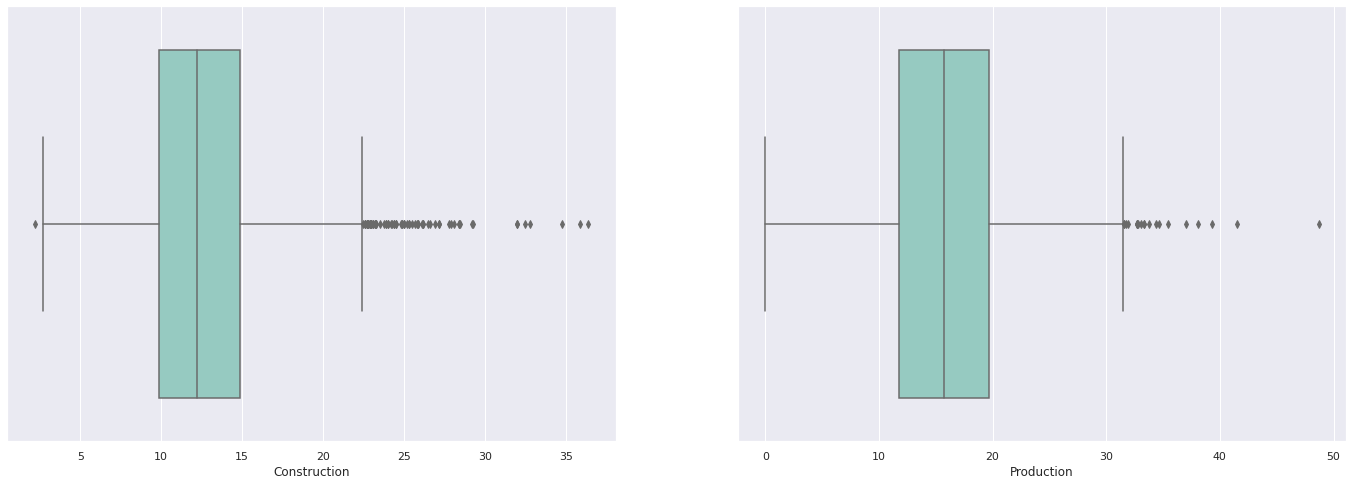

In [44]:
f, axes = plt.subplots(1,2, figsize=(24,8))

sns.boxplot(x="Construction" , data=sector_covid_df, palette="Set3",ax=axes[0])
sns.boxplot(x="Production" , data=sector_covid_df, palette="Set3", ax=axes[1])

Removing the outliers since we can see from the graphs that the data is skewed:

In [45]:
processed_sector_covid_df = sector_covid_df
dct_sector = mapToInt(processed_sector_covid_df, 'county', True, 'linear')

z = np.abs(stats.zscore(processed_sector_covid_df))
processed_sector_covid_df = processed_sector_covid_df[(z < 3).all(axis=1)]
processed_sector_covid_df
processed_sector_covid_df.set_index('county')

Professional  Service  Office  ...  Production  pctCases    cases
county                                 ...                               
1               27.2     20.7    20.8  ...        20.7  0.032475    805.0
2               27.6     16.9    25.7  ...        14.8  0.050825   3182.0
3               31.1     17.7    18.8  ...        17.3  0.037363   1227.0
4               43.0     16.6    25.0  ...         8.4  0.040106  17451.0
5               28.2     16.9    20.0  ...        17.6  0.030868    222.0
...              ...      ...     ...  ...         ...       ...      ...
1763            31.5     17.8    21.9  ...        13.7  0.034130    620.0
1764            29.3     19.9    24.1  ...        13.0  0.018126   1353.0
1765            24.9     23.0    22.8  ...        12.0  0.068504  13994.0
1765            29.4     14.4    22.2  ...        12.6  0.022455    227.0
1767            29.0     24.3    14.7  ...        15.3  0.038677    470.0

[2858 rows x 7 columns]

##Sector/Covid Correlation Analysis

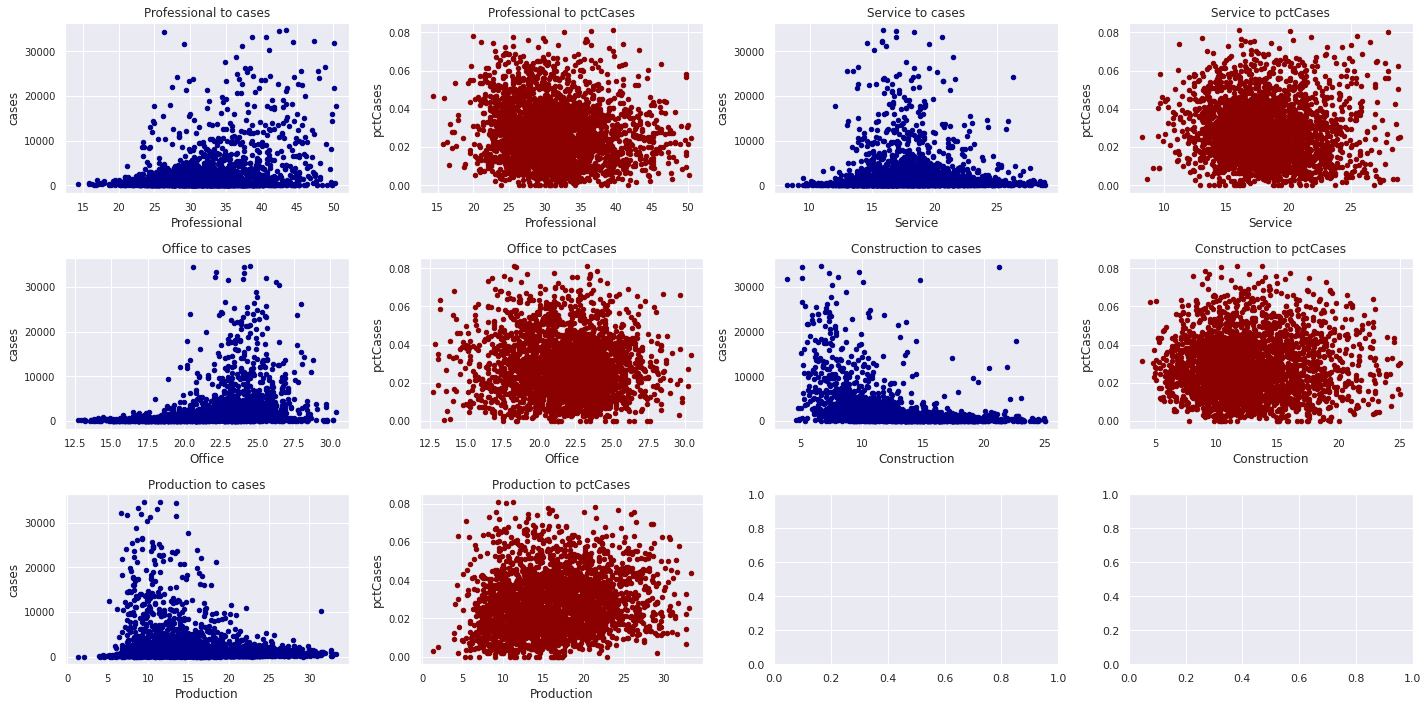

In [46]:
fig, ax = plt.subplots(nrows = 3, ncols=4, figsize= (20,10))
processed_sector_covid_df.plot(kind='scatter', x='Professional', y='cases',title="Professional to cases", grid=True,fontsize=10, color="DarkBlue", ax=ax[0,0])
processed_sector_covid_df.plot(kind='scatter', x='Professional', y='pctCases',title="Professional to pctCases", grid=True,fontsize=10, color="DarkRed" , ax=ax[0,1])

processed_sector_covid_df.plot(kind='scatter', x='Service', y='cases',title="Service to cases", grid=True,fontsize=10, color="DarkBlue", ax=ax[0,2]) 
processed_sector_covid_df.plot(kind='scatter', x='Service', y='pctCases',title="Service to pctCases", grid=True,fontsize=10, color="DarkRed", ax=ax[0,3]) 

processed_sector_covid_df.plot(kind='scatter', x='Office', y='cases',title="Office to cases", grid=True,fontsize=10, color="DarkBlue", ax=ax[1,0]) 
processed_sector_covid_df.plot(kind='scatter', x='Office', y='pctCases',title="Office to pctCases", grid=True,fontsize=10, color="DarkRed", ax=ax[1,1]) 

processed_sector_covid_df.plot(kind='scatter', x='Construction', y='cases',title="Construction to cases", grid=True,fontsize=10, color="DarkBlue", ax=ax[1,2]) 
processed_sector_covid_df.plot(kind='scatter', x='Construction', y='pctCases',title="Construction to pctCases", grid=True,fontsize=10, color="DarkRed", ax=ax[1,3]) 

processed_sector_covid_df.plot(kind='scatter', x='Production', y='cases',title="Production to cases", grid=True,fontsize=10, color="DarkBlue", ax=ax[2,0]) 
processed_sector_covid_df.plot(kind='scatter', x='Production', y='pctCases',title="Production to pctCases", grid=True,fontsize=10, color="DarkRed", ax=ax[2,1]) 

fig.tight_layout()

county  Professional   Service  ...  Production  pctCases     cases
county        1.000000     -0.003488  0.012085  ...    0.000551 -0.007627  0.012590
Professional -0.003488      1.000000 -0.242625  ...   -0.677881 -0.111171  0.326712
Service       0.012085     -0.242625  1.000000  ...   -0.242051 -0.044265 -0.015602
Office       -0.024013      0.036982 -0.007810  ...   -0.278193 -0.043884  0.292642
Construction  0.012916     -0.367379 -0.122577  ...   -0.009951  0.029905 -0.371782
Production    0.000551     -0.677881 -0.242051  ...    1.000000  0.144605 -0.233527
pctCases     -0.007627     -0.111171 -0.044265  ...    0.144605  1.000000  0.158836
cases         0.012590      0.326712 -0.015602  ...   -0.233527  0.158836  1.000000

[8 rows x 8 columns]

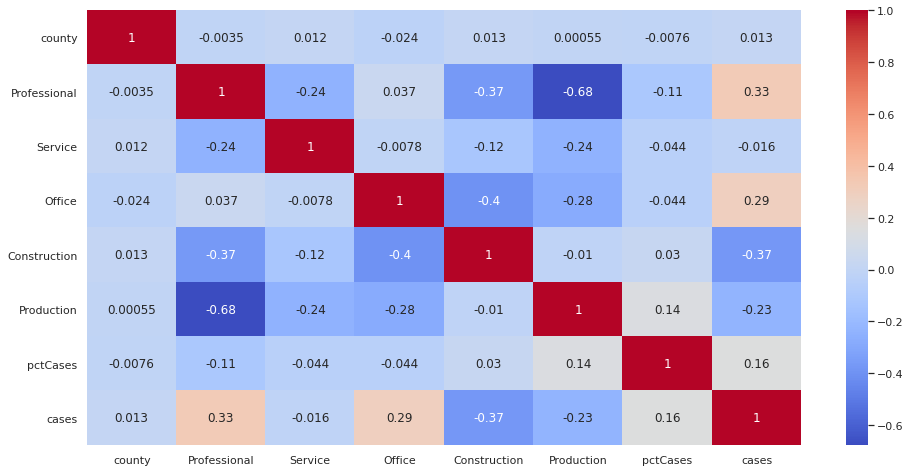

In [47]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = processed_sector_covid_df.corr()

sns.heatmap(corr, annot=True,cmap = "coolwarm")
processed_sector_covid_df.corr(method='pearson', min_periods=1)

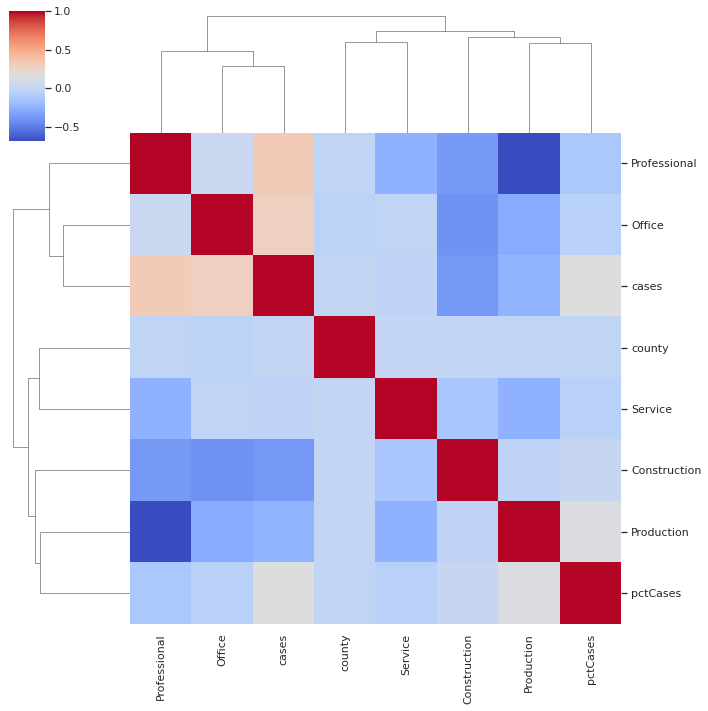

In [48]:
sns.clustermap(corr, cmap="coolwarm")

## Sector/Covid Correlation Conclusion

From the visualizations it appears that there is no great correlation between the different job sectors and covid.

##Analysis - Sector/Election

The next section performs visualizations to see if there are any correlations between job sectors and election results of 2016.

##Sector/Election Correlation

In [49]:
sector_2016_df = select_sector_columns_2016.copy()
sector_2016_df.set_index('county')

Professional  Service  ...  votes16_Donald_Trump  votes16_Hillary_Clinton
county                            ...                                               
Abbeville          27.2     20.7  ...                6742.0                   3712.0
Acadia             27.6     16.9  ...               21159.0                   5638.0
Accomack           31.1     17.7  ...                8582.0                   6737.0
Ada                43.0     16.6  ...               93748.0                  75676.0
Adair              28.2     16.9  ...                2456.0                   1127.0
...                 ...      ...  ...                   ...                      ...
Yuma               24.9     23.0  ...               20586.0                  18336.0
Yuma               29.4     14.4  ...                3755.0                    701.0
Zapata             17.7     30.4  ...                1028.0                   2056.0
Zavala             29.0     24.3  ...                 692.0                   2633.0
Ziebach            51.3     15.9  ...                 368.0                    352.0

[3046 rows x 10 columns]

In [50]:
sector_2016_df.describe()

Professional      Service  ...  votes16_Donald_Trump  votes16_Hillary_Clinton
count   3046.000000  3046.000000  ...           3046.000000             3.046000e+03
mean      31.423244    18.077183  ...          19358.344714             1.924069e+04
std        6.426838     3.657206  ...          39264.260944             6.835977e+04
min       11.400000     0.000000  ...             57.000000             4.000000e+00
25%       27.200000    15.700000  ...           3206.500000             1.144500e+03
50%       30.500000    17.700000  ...           7113.000000             3.069500e+03
75%       34.800000    20.000000  ...          17315.250000             9.192250e+03
max       69.000000    46.400000  ...         590465.000000             1.654626e+06

[8 rows x 10 columns]

In [51]:
dct_sector = mapToInt(sector_2016_df, 'county', True, 'linear')

z = np.abs(stats.zscore(sector_2016_df))
processed_sector_2016_df = sector_2016_df[(z < 3).all(axis=1)]
processed_sector_2016_df
processed_sector_2016_df.set_index('county')

Professional  Service  ...  votes16_Donald_Trump  votes16_Hillary_Clinton
county                         ...                                               
1               27.2     20.7  ...                6742.0                   3712.0
2               27.6     16.9  ...               21159.0                   5638.0
3               31.1     17.7  ...                8582.0                   6737.0
4               43.0     16.6  ...               93748.0                  75676.0
5               28.2     16.9  ...                2456.0                   1127.0
...              ...      ...  ...                   ...                      ...
1762            49.7     14.6  ...               18823.0                  12989.0
1763            31.5     17.8  ...                6587.0                    873.0
1764            29.3     19.9  ...                8869.0                   5115.0
1765            24.9     23.0  ...               20586.0                  18336.0
1765            29.4     14.4  ...                3755.0                    701.0

[2829 rows x 10 columns]

##Sector/Election Correlation Analysis



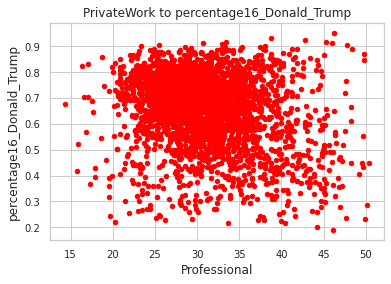

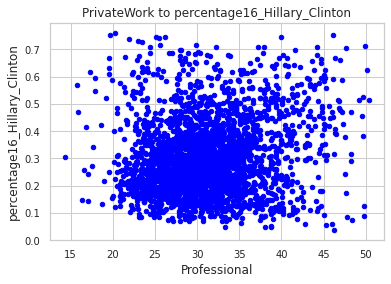

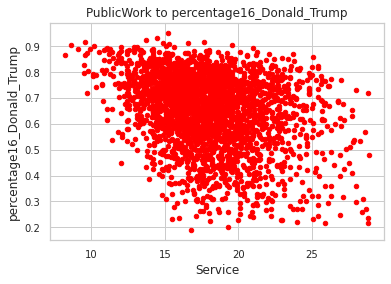

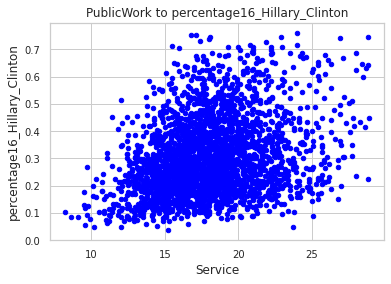

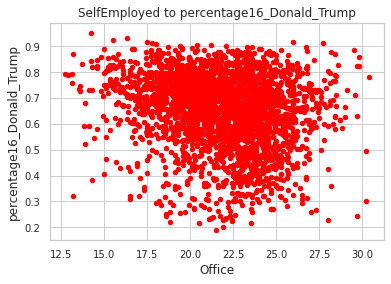

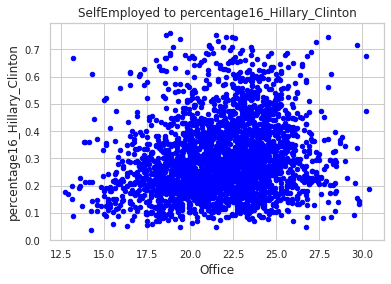

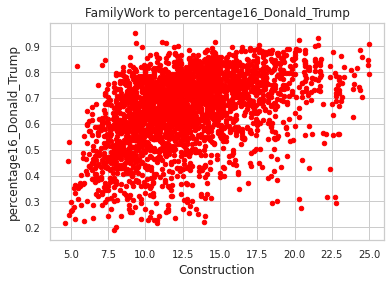

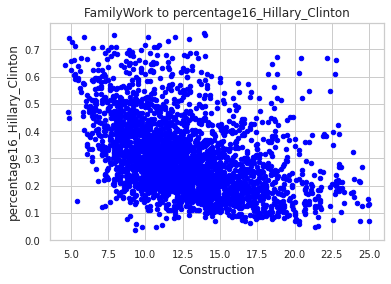

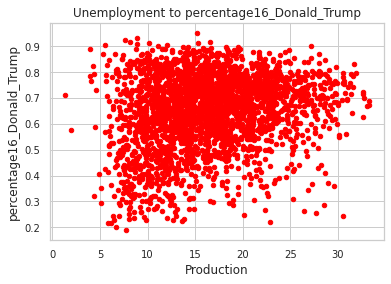

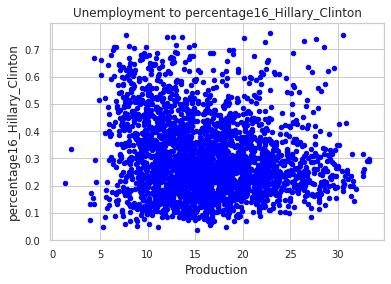

In [52]:
processed_sector_2016_df.plot(kind='scatter', x='Professional', y='percentage16_Donald_Trump',title="PrivateWork to percentage16_Donald_Trump", grid=True,fontsize=10, color="Red") 
processed_sector_2016_df.plot(kind='scatter', x='Professional', y='percentage16_Hillary_Clinton',title="PrivateWork to percentage16_Hillary_Clinton", grid=True,fontsize=10, color="Blue") 

processed_sector_2016_df.plot(kind='scatter', x='Service', y='percentage16_Donald_Trump',title="PublicWork to percentage16_Donald_Trump", grid=True,fontsize=10, color="Red") 
processed_sector_2016_df.plot(kind='scatter', x='Service', y='percentage16_Hillary_Clinton',title="PublicWork to percentage16_Hillary_Clinton", grid=True,fontsize=10, color="Blue") 

processed_sector_2016_df.plot(kind='scatter', x='Office', y='percentage16_Donald_Trump',title="SelfEmployed to percentage16_Donald_Trump", grid=True,fontsize=10, color="Red") 
processed_sector_2016_df.plot(kind='scatter', x='Office', y='percentage16_Hillary_Clinton',title="SelfEmployed to percentage16_Hillary_Clinton", grid=True,fontsize=10, color="Blue") 

processed_sector_2016_df.plot(kind='scatter', x='Construction', y='percentage16_Donald_Trump',title="FamilyWork to percentage16_Donald_Trump", grid=True,fontsize=10, color="Red") 
processed_sector_2016_df.plot(kind='scatter', x='Construction', y='percentage16_Hillary_Clinton',title="FamilyWork to percentage16_Hillary_Clinton", grid=True,fontsize=10, color="Blue") 

processed_sector_2016_df.plot(kind='scatter', x='Production', y='percentage16_Donald_Trump',title="Unemployment to percentage16_Donald_Trump", grid=True,fontsize=10, color="Red") 
processed_sector_2016_df.plot(kind='scatter', x='Production', y='percentage16_Hillary_Clinton',title="Unemployment to percentage16_Hillary_Clinton", grid=True,fontsize=10, color="Blue") 

county  ...  votes16_Hillary_Clinton
county                        1.000000  ...                 0.010270
Professional                 -0.004712  ...                 0.366803
Service                       0.007560  ...                 0.008340
Office                       -0.019791  ...                 0.282628
Construction                  0.009554  ...                -0.410570
Production                    0.004488  ...                -0.251573
percentage16_Donald_Trump    -0.024830  ...                -0.498923
percentage16_Hillary_Clinton  0.022983  ...                 0.494383
total_votes16                 0.013798  ...                 0.966770
votes16_Donald_Trump          0.014946  ...                 0.853217
votes16_Hillary_Clinton       0.010270  ...                 1.000000

[11 rows x 11 columns]

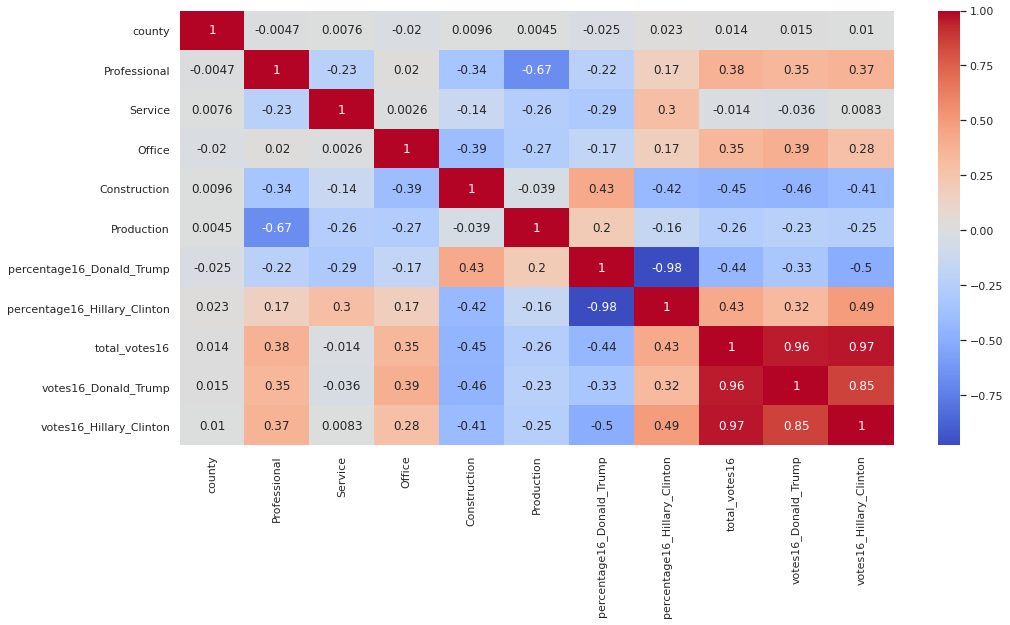

In [53]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
sector_election_corr = processed_sector_2016_df.corr()

sns.heatmap(sector_election_corr, annot=True,cmap = "coolwarm")
processed_sector_2016_df.corr(method='pearson', min_periods=1)

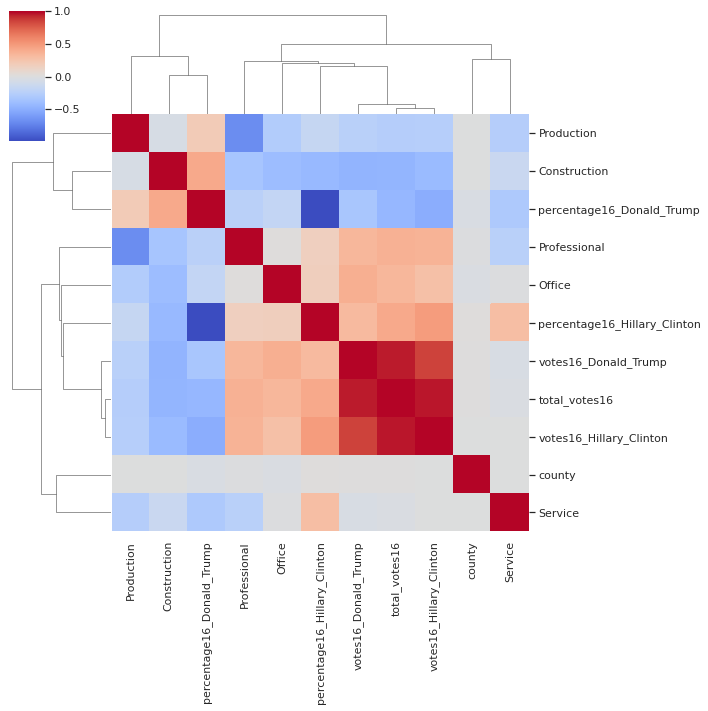

In [54]:
sns.clustermap(sector_election_corr, cmap="coolwarm")

### Gender

In [55]:
#Gehder
Gender_columns_2016 = df[["Men","Women","county","percentage16_Donald_Trump","percentage16_Hillary_Clinton", 'total_votes16', 'votes16_Donald_Trump', 'votes16_Hillary_Clinton']].copy().dropna()
Gender_columns_covid = df[['Men', 'Women','pctCases']].copy().dropna()


## COVID vs Gender

In [56]:
Gender_columns_covid.describe()

Men         Women     pctCases
count  3.046000e+03  3.046000e+03  3046.000000
mean   5.041840e+04  5.198089e+04     0.028587
std    1.627635e+05  1.687475e+05     0.017564
min    3.900000e+01  3.500000e+01     0.000000
25%    5.544000e+03  5.495000e+03     0.016524
50%    1.282450e+04  1.288700e+04     0.026154
75%    3.325625e+04  3.371675e+04     0.037638
max    4.979641e+06  5.126081e+06     0.204605

The numbers between min and max hold a very wide range so we need to normalize the values

In [57]:
Gender_columns_covid['Men'] = (Gender_columns_covid['Men'] - min(Gender_columns_covid['Men']))/(max(Gender_columns_covid['Men']) - min(Gender_columns_covid['Men']))
Gender_columns_covid['Women'] = (Gender_columns_covid['Women'] - min(Gender_columns_covid['Women']))/(max(Gender_columns_covid['Women']) - min(Gender_columns_covid['Women']))
Gender_columns_covid

Men     Women  pctCases
0     0.002411  0.002479  0.032475
1     0.006104  0.006270  0.050825
2     0.003221  0.003263  0.037363
3     0.043771  0.042349  0.040106
4     0.000705  0.000703  0.030868
...        ...       ...       ...
3106  0.021061  0.019378  0.068504
3107  0.000998  0.000988  0.022455
3108  0.001436  0.001403  0.024835
3109  0.001230  0.001162  0.038677
3110  0.000278  0.000269  0.038068

[3046 rows x 3 columns]

# Correltion between gender and pctCases

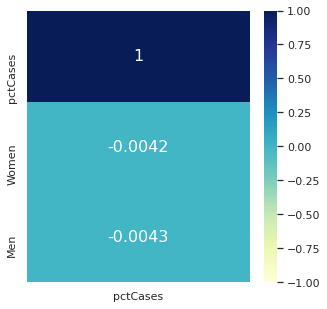

In [58]:
fig, ax = plt.subplots(figsize = (5,5))
sns.heatmap(Gender_columns_covid.corr()[['pctCases']].sort_values('pctCases').tail(6), vmax = 1, vmin = -1, cmap = 'YlGnBu', annot_kws = {'size':16}, annot = True, ax = ax);
ax.invert_yaxis()

It seems like there is a normal distribution in both genders

## Z-score outliers elimination

In [59]:
z_score = stats.zscore(Gender_columns_covid)
abs_Z_scores = np.abs(z_score)
filtered = (abs_Z_scores  < 3).all(axis=1)
new_gender_columns_covid = Gender_columns_covid[filtered]
new_gender_columns_covid.describe()

Men        Women     pctCases
count  2975.000000  2975.000000  2975.000000
mean      0.007550     0.007544     0.027681
std       0.014319     0.014556     0.015246
min       0.000000     0.000000     0.000000
25%       0.001103     0.001065     0.016398
50%       0.002551     0.002498     0.025873
75%       0.006455     0.006332     0.037353
max       0.100717     0.104875     0.081042

Scatter plot without outliars

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


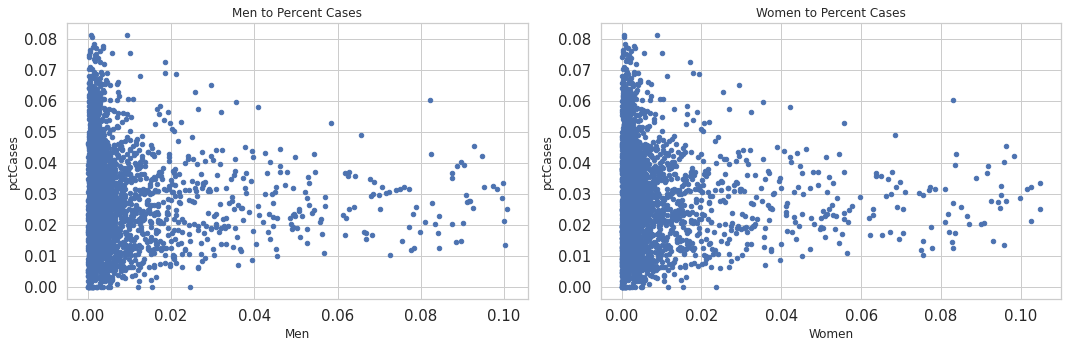

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
new_gender_columns_covid.plot(kind='scatter', x='Men', y='pctCases', title="Men to Percent Cases", grid=True, fontsize = 15, ax = axes[0])
new_gender_columns_covid.plot(kind='scatter', x='Women', y='pctCases', title = "Women to Percent Cases", grid=True, fontsize = 15, ax = axes[1])
fig.tight_layout()
plt.show()

## Result of outliar removal on heatmap correlation

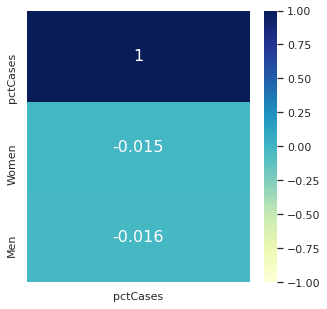

In [61]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(new_gender_columns_covid.corr()[['pctCases']].sort_values('pctCases').tail(6),
 vmax=1, vmin=-1, cmap='YlGnBu', annot=True, annot_kws={'size':16}, ax=ax);
ax.invert_yaxis()

From data before there isn't much change so the outliers so they did not affect that data. looking at the heat maps it appears the gender is not a correlated with getting covid

##Correlation between Gender and voting

In [62]:
Gender_columns_2016.describe()

Men  ...  votes16_Hillary_Clinton
count  3.046000e+03  ...             3.046000e+03
mean   5.041840e+04  ...             1.924069e+04
std    1.627635e+05  ...             6.835977e+04
min    3.900000e+01  ...             4.000000e+00
25%    5.544000e+03  ...             1.144500e+03
50%    1.282450e+04  ...             3.069500e+03
75%    3.325625e+04  ...             9.192250e+03
max    4.979641e+06  ...             1.654626e+06

[8 rows x 7 columns]

We will see how the gender correlate with voting preferences and adjust accordingly removing outliars

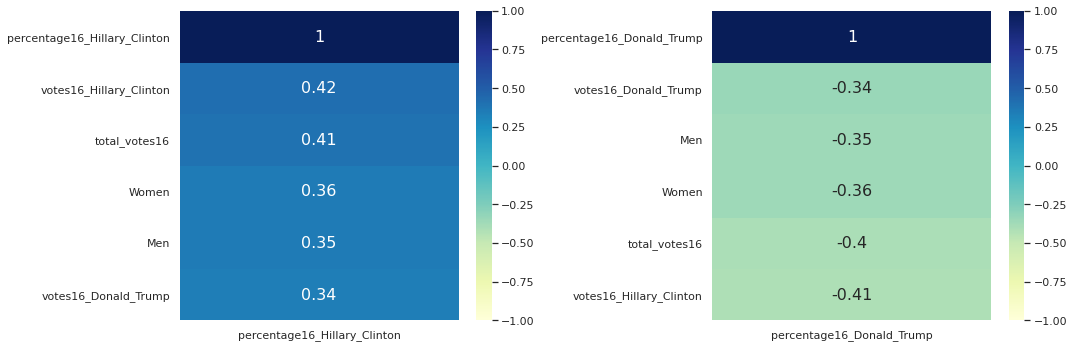

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(Gender_columns_2016.corr()[['percentage16_Hillary_Clinton']].sort_values('percentage16_Hillary_Clinton').tail(6), annot_kws={'size':16}, vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax[0]);
sns.heatmap(Gender_columns_2016.corr()[['percentage16_Donald_Trump']].sort_values('percentage16_Donald_Trump').tail(6),annot_kws={'size':16}, vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax[1]);
fig.tight_layout()
ax[0].invert_yaxis()
ax[1].invert_yaxis()

In [64]:
Gender_columns_2016 = Gender_columns_2016.set_index('county')
z_scores = stats.zscore(Gender_columns_2016)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_gender_cols_2016 = Gender_columns_2016[filtered_entries]
new_gender_cols_2016.describe()

Men  ...  votes16_Hillary_Clinton
count    2942.000000  ...              2942.000000
mean    31515.539429  ...             10689.805235
std     54840.740259  ...             23707.642175
min        39.000000  ...                 4.000000
25%      5429.500000  ...              1101.000000
50%     12323.500000  ...              2878.000000
75%     30073.500000  ...              8129.000000
max    498993.000000  ...            219129.000000

[8 rows x 7 columns]

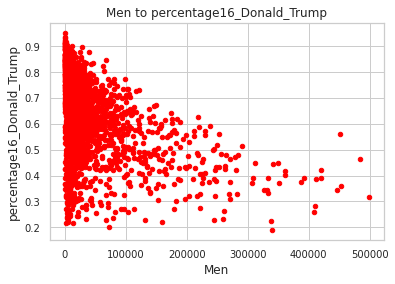

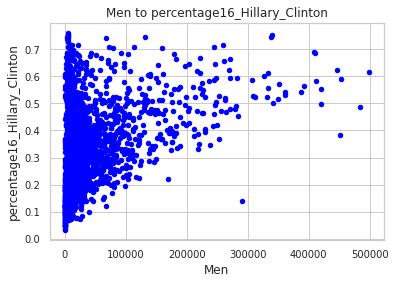

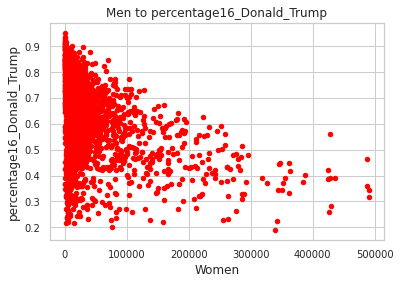

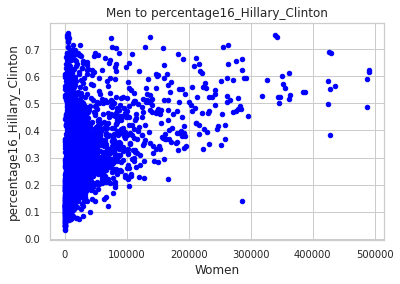

In [65]:
new_gender_cols_2016.plot(kind='scatter', x='Men', y='percentage16_Donald_Trump',title="Men to percentage16_Donald_Trump", grid=True,fontsize=10, color="Red") 
new_gender_cols_2016.plot(kind='scatter', x='Men', y='percentage16_Hillary_Clinton',title="Men to percentage16_Hillary_Clinton", grid=True,fontsize=10, color="Blue") 

new_gender_cols_2016.plot(kind='scatter', x='Women', y='percentage16_Donald_Trump',title="Men to percentage16_Donald_Trump", grid=True,fontsize=10, color="Red") 
new_gender_cols_2016.plot(kind='scatter', x='Women', y='percentage16_Hillary_Clinton',title="Men to percentage16_Hillary_Clinton", grid=True,fontsize=10, color="Blue") 


Men  ...  votes16_Hillary_Clinton
Men                           1.000000  ...                 0.993880
Women                         0.999990  ...                 0.994221
percentage16_Donald_Trump    -0.740207  ...                -0.790765
percentage16_Hillary_Clinton  0.726505  ...                 0.778439
total_votes16                 0.997972  ...                 0.994512
votes16_Donald_Trump          0.987274  ...                 0.971902
votes16_Hillary_Clinton       0.993880  ...                 1.000000

[7 rows x 7 columns]

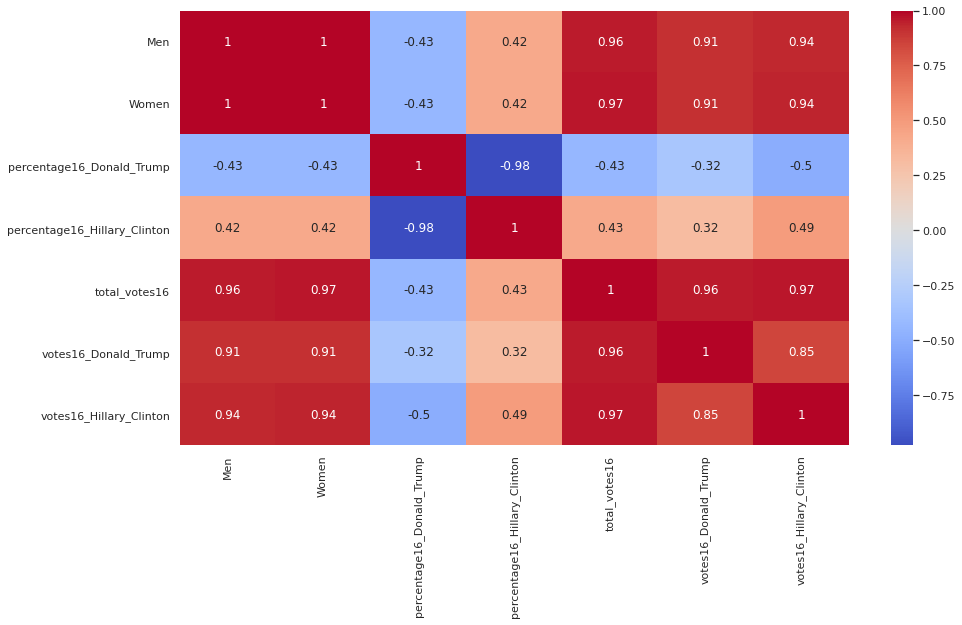

In [66]:
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")
new_gender_cols_2016 = new_gender_cols_2016.corr()

sns.heatmap(new_gender_cols_2016, annot=True,cmap = "coolwarm")
new_gender_cols_2016.corr(method='pearson', min_periods=1)

From the heat map it appears like men and women vote in similar ways, or gender does not determine political allignment